# TITLE

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Description

<b>Author: João Keselik<br>
Date: 21-06-2020<br></b>
<br>
The aim of this project is to evaluate the trading of secondhand products on a Swedish online marketplace, determining the dimension of the potential environmental benefits achieved by the reuse of products compared to the purchase of new products. The objectives are: <br>
•	To define the characteristics of the secondhand market of consumer goods.<br>
•	To specify the geographic distribution of the market among Swedish regions.<br>
•	To determine the dimension of the potential environmental benefits, excluding rebound effects.<br>
•	To establish the dimension of the potential environmental rebound effects related to imperfect substitution, reinvestment and respending.

# Packages

In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
import xlsxwriter
import re
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import six
import pymrio

In [4]:
print("requests version: %s" % requests.__version__)
print("BeautifulSoup version:%6.6s" % bs4.__version__)
print("XlsxWriter version: %s" % xlsxwriter.__version__)
print("re version: %s" % re.__version__)
print("pandas version: %s" % pd.__version__)
print("matplotlib version: %s" % matplotlib.__version__)
print("NumPy version: %s" % np.__version__)
print("six version: %s" % six.__version__)
print("pymrio version: %s" % pymrio.__version__)

requests version: 2.22.0
BeautifulSoup version: 4.8.1
XlsxWriter version: 1.2.6
re version: 2.2.1
pandas version: 0.25.3
matplotlib version: 3.1.1
NumPy version: 1.17.4
six version: 1.13.0
pymrio version: 0.4.1


# Constants

In [2]:
M_EUR=10**6
EUR_TO_SEK = 10.554847208 #https://www.xe.com/ 2020-02-05
USD_TO_SEK = 9.55993   #https://www.xe.com/
INFLATION_EUR_2011_2020 = 1.1 #https://www.inflationtool.com/

# Defined functions

Function to save pandas DataFrames as images:

In [3]:
def render_mpl_table(data, index_col_width=3.0, col_width=4.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w', 
                     bbox=[0, 0, 1, 1], header_columns=0, index='yes',
                     ax=None, **kwargs):
    if ax is None:       
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height]) + (index_col_width, 0)
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    
    if index=='no':
        mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)        
    else:
        mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, rowLabels=data.index, **kwargs)
    #mpl_table.auto_set_column_width(col=[0,1,2,3,4])
    mpl_table.auto_set_column_width(col=[0,1,2,3,4,5,6,7,8,9])

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)  

    for k, cell in six.iteritems(mpl_table._cells):        
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])        
        
    return ax


# Web scraping a Swedish online marketplace

In [ ]:
#website has changed its html structure, therefore this script does not longer work 

workbook = xlsxwriter.Workbook('dataset/data_privat_collected 2019-10-28.xlsx')
worksheet = workbook.add_worksheet()
bold = workbook.add_format({'bold': 1})
worksheet.set_column(0, 0, 50)
worksheet.set_column(1, 1, 30)
worksheet.set_column(2, 2, 20)
worksheet.set_column(3, 3, 20)
worksheet.write_string(0, 0, "Item", bold)
worksheet.write_string(0, 1, "Price", bold)
worksheet.write_string(0, 2, "Category", bold)
worksheet.write_string(0, 3, "Region", bold)

row = 1
col = 0

url = 'https://www.blocket.se/hela_sverige?ca=11&st=s&f=p&w=3'

while not url.endswith('&last=1'):  
    
    response = requests.get(url)    
    try:    
        response.raise_for_status() 
    except Exception as exc:    
        print('There was a problem: %s' % (exc))

    soup = BeautifulSoup(response.text, "html.parser")

    items = soup.find_all("a", "item_link")
    prices = soup.find_all("p", "list_price") 
    categories = soup.find_all('a', {'tabindex': '-1'})
    regions = soup.find_all('div', 'pull-left')

    for item_a, price_p, category_a, region_div in zip(items, prices, categories, regions[6:]):
         item = item_a.string.strip()   

         price = price_p.text
         if not price:
             price = "NULL"

         category = category_a.text
         if not(re.search(r"Lägenheter|Utland|Djur|Villor|Tjänster|Lokaler & fastigheter|Affärsöverlåtelser|Upplevelser & nöje|Tomter|Gårdar|Efterlysningar|Fritidsboende|Radhus", category)) and not(re.search(r"Jobb", region_div.text)):
             region = region_div.text.split(',')[-1]          
             worksheet.write_string(row, col, item)
             worksheet.write_string(row, col + 1, price)
             worksheet.write_string(row, col + 2, category)        
             worksheet.write_string(row, col + 3, region)             
             row += 1     
         
    nextLink = soup.find_all('a', 'page_nav')[5]
    if not "Nästa sida »" in nextLink.decode_contents().strip():
        nextLink = soup.find_all('a', 'page_nav')[6]
        if not "Nästa sida »" in nextLink.decode_contents().strip():  
            nextLink = soup.find_all('a', 'page_nav')[7]               
    
    nextLinkSuffix = nextLink.get('href')     
    url = 'https://www.blocket.se/hela_sverige' + nextLinkSuffix     

workbook.close() 

# Data analysis

In [4]:
%matplotlib inline

Opening excel file:

In [5]:
excel_file = (r'dataset/data_privat_collected 2019-10-28.xlsx')
df = pd.read_excel(excel_file)

## Data preparation

Converting Price from string to float:

In [6]:
df_dirty = df.copy()
df_dirty['Price'] = df_dirty['Price'].str.replace('kr', '').str.replace(' ', '').astype(float)

Removing rows with NaN values from the Price column:

In [7]:
df_dirty = df_dirty[pd.notnull(df_dirty['Price'])]

Glancing at the maximum values for the Prices by Category it is possible to notice that outliers ought to be removed:

In [8]:
df_dirty.groupby('Category')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Accessoarer & klockor,4476.0,11441.567471,4.804882e+04,2.0,600.0,1500.0,5500.0,2300000.0
Barnartiklar & leksaker,16145.0,1271.536823,2.266256e+03,1.0,300.0,500.0,1400.0,123456.0
Barnkläder & skor,9041.0,307.217343,1.414491e+03,1.0,100.0,200.0,350.0,123456.0
Bilar,24254.0,86168.530840,6.559600e+05,10.0,18000.0,45000.0,104000.0,99999999.0
Bildelar & biltillbehör,26497.0,6702.555987,1.831094e+05,1.0,1000.0,2300.0,4500.0,12345678.0
Bygg & trädgård,16122.0,6281.774408,1.872384e+05,1.0,500.0,1100.0,3200.0,20002500.0
Båtar,4041.0,177365.909181,5.243814e+05,50.0,20000.0,65000.0,160000.0,19900000.0
Båtdelar & tillbehör,2537.0,14690.642097,2.461327e+05,1.0,1350.0,4000.0,9500.0,12345678.0
Böcker & studentlitteratur,3270.0,8157.921407,3.053015e+05,1.0,100.0,200.0,350.0,12345678.0


Removing outliers, i.e. prices that differ significantly from other observations:

In [9]:
df_cleaned = pd.DataFrame(columns=df.columns)

for category in df_dirty['Category'].unique().tolist(): 
    df_category = df_dirty.loc[df_dirty['Category'] == category].copy()      

    df_category = df_category[np.abs(df_category['Price']-df_category['Price'].mean()) <= (3*df_category['Price'].std())]
    df_cleaned = df_cleaned.append(df_category)    

df_cleaned.sort_index()

,Item,Price,Category,Region
0,KTM 85cc -09,6500.0,Motorcyklar,Östergötland
1,Dubbdäck 195/55R15,600.0,Bildelar & biltillbehör,Kalmar
2,Griffel- o magnettavla anslagstavla Luns IKEA,65.0,Möbler & heminredning,Lund
3,Dyk utrustning,1500.0,Sport- & fritidsutrustning,Helsingborg
4,Bordslampa,700.0,Möbler & heminredning,Stockholm
...,...,...,...,...
269848,Komplett pellets anläggning,7200.0,Bygg & trädgård,Ystad
269849,Mc ställ,2500.0,MC-delar & tillbehör,Skaraborg
269850,Kapmaskin Bofors,5000.0,Inventarier & maskiner,Västmanland
269851,Low Rider -07,119900.0,Motorcyklar,Halland


In [10]:
df_dirty.count()

Item        258019
Price       258019
Category    258019
Region      258019
dtype: int64

Number of rows removed due to outliers:

In [11]:
df_dirty.count()-df_cleaned.count()

Item        837
Price       837
Category    837
Region      837
dtype: int64

Variable df receives the cleaned data:

In [12]:
df = df_cleaned.copy()

## Regions

List of regions:

In [16]:
for region in df['Region'].unique().tolist():
    print(region)

 Östergötland
 Göteborg
 Halland
 Stockholm
 Älvsborg
 Gävleborg
 Gotland
 Uppsala
 Kristianstad
 Södermanland
 Örebro
 Jönköping
 Malmö
 Lund
 Dalarna
 Jämtland
 Luleå
 Skaraborg
 Helsingborg
 Värmland
 Kronoberg
 Trelleborg
 Västmanland
 Piteå
 Västerbotten
 Västernorrland
 Landskrona
 Hässleholm
 Haparanda
 Blekinge
 Kalmar
 Arjeplog
 Simrishamn
 Klippan
 Ystad
 Ängelholm
 Boden
 Osby
 Kiruna
 Eslöv
 Hörby
 Kalix
 Båstad
 Jokkmokk
 Gällivare
 Höör
 Arvidsjaur
 Älvsbyn
 Överkalix
 Övertorneå
 Pajala


## Categories

List of categories:

In [14]:
for category in df['Category'].unique().tolist():
    print(category)

Motorcyklar
Bildelar & biltillbehör
Möbler & heminredning
Sport- & fritidsutrustning
Barnkläder & skor
MC-delar & tillbehör
Ljud & bild
Bilar
Datorer & TV-spel
Bygg & trädgård
Övrigt
Husgeråd & vitvaror
Kläder & skor
Barnartiklar & leksaker
Husvagnar & husbilar
Skogs- & lantbruksmaskiner
Musikutrustning
Inventarier & maskiner
Telefoner & tillbehör
Böcker & studentlitteratur
Verktyg
Hästar & ridsport
Båtdelar & tillbehör
Mopeder & A-traktor
Cyklar
Lastbil, truck & entreprenad
Båtar
Snöskotrar
Accessoarer & klockor
Hobby & samlarprylar
Jakt & fiske
Snöskoterdelar & tillbehör


Categories in English:

- Motorcyklar - Motorcycles <br>
- Bildelar & biltillbehör - Car parts & car accessories<br>
- Möbler & heminredning - Furniture & home decor<br>
- Sport- & fritidsutrustning - Sports & leisure equipment<br>
- Barnkläder & skor - Children's clothing & shoes<br>
- MC-delar & tillbehör - Motorcycle parts & accessories<br>
- Ljud & bild - Audio & video<br>
- Bilar - Cars<br>
- Datorer & TV-spel - Computers & video games<br>
- Bygg & trädgård - Construction & garden<br>
- Övrigt - Other<br>
- Husgeråd & vitvaror - Housewares & appliances<br>
- Kläder & skor - Clothes & shoes
- Barnartiklar & leksaker - Children's articles & toys<br>
- Husvagnar & husbilar - Caravans & campers<br>
- Skogs- & lantbruksmaskiner - Forestry & agricultural machinery<br>
- Musikutrustning - Music equipment<br>
- Inventarier & maskiner - Fixtures & machines<br>
- Telefoner & tillbehör - Phones & accessories<br>
- Böcker & studentlitteratur - Books & student literature<br>
- Verktyg - Tools<br>
- Hästar & ridsport - Horses & equestrian<br>
- Båtdelar & tillbehör - Boat parts & accessories<br>
- Mopeder & A-traktor - Mopeds & doodlebug tractors<br>
- Cyklar - Bicycles<br>
- Lastbil, truck & entreprenad - Truck & construction<br>
- Båtar - Boats<br>
- Snöskotrar - Snowmobiles<br>
- Accessoarer & klockor - Accessories & watches<br>
- Hobby & samlarprylar - Hobby & collectibles<br>
- Jakt & fiske - Hunting & fishing<br>
- Snöskoterdelar & tillbehör - Snowmobile parts & accessories<br>

## Characteristics

### Example of the collected data

In [63]:
df_sample=pd.DataFrame(df.sort_index().head(15))

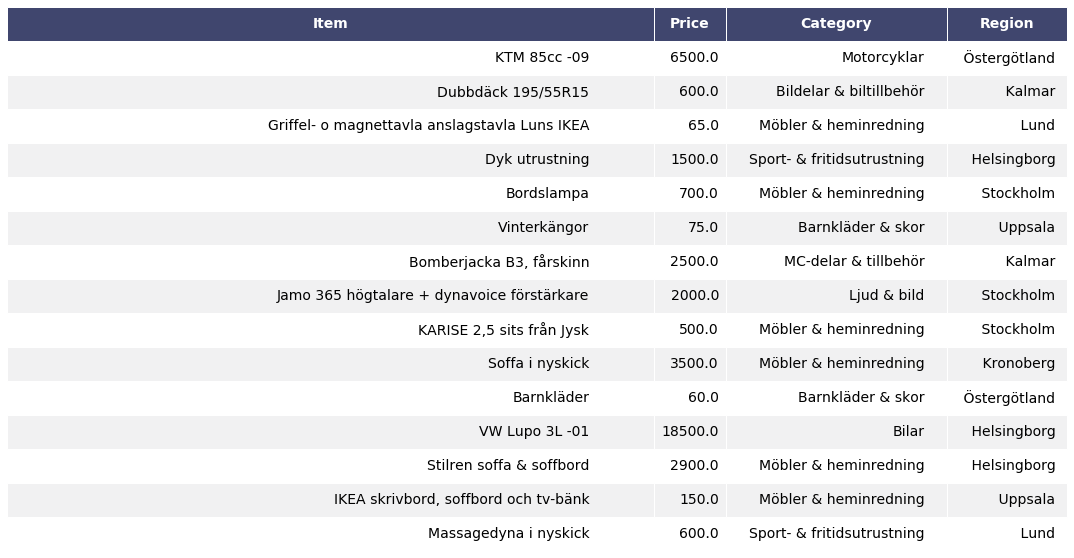

In [33]:
fig = render_mpl_table(df_sample, header_columns=0, col_width=4.0, index='no').get_figure()
fig.savefig('tables/example.png')

### Data description

Describing Category:

In [34]:
df_category = pd.DataFrame(df['Category'].describe())

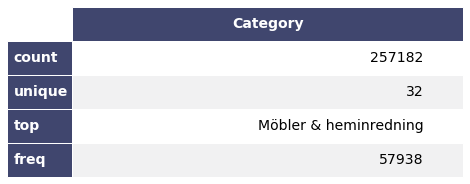

In [35]:
fig = render_mpl_table(df_category, header_columns=0, col_width=5.0, index_col_width=2.0).get_figure()
fig.savefig('tables/category.png')

Describing Region:

In [68]:
df_region = pd.DataFrame(df['Region'].describe())

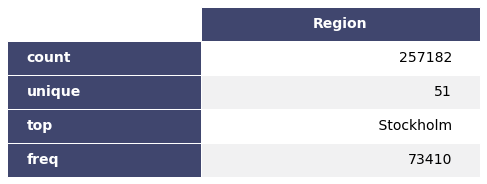

In [72]:
fig = render_mpl_table(df_region, header_columns=0, col_width=3.0, index_col_width=2.0).get_figure()
fig.savefig('tables/region.png', bbox_inches = "tight")

Describing Price:

In [74]:
df_price=pd.DataFrame(df['Price'].describe())

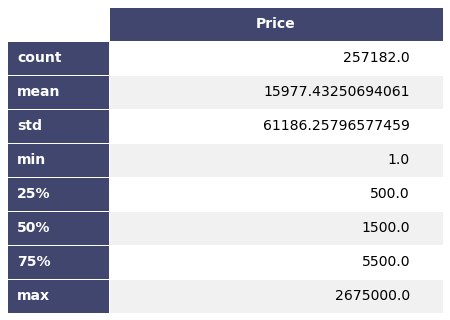

In [75]:
fig = render_mpl_table(df_price, header_columns=0, col_width=5.0, index_col_width=1.0).get_figure()
fig.savefig('tables/price.png')

Describing Category by Region:

In [64]:
df_category_by_region = df.groupby('Region')['Category'].describe()

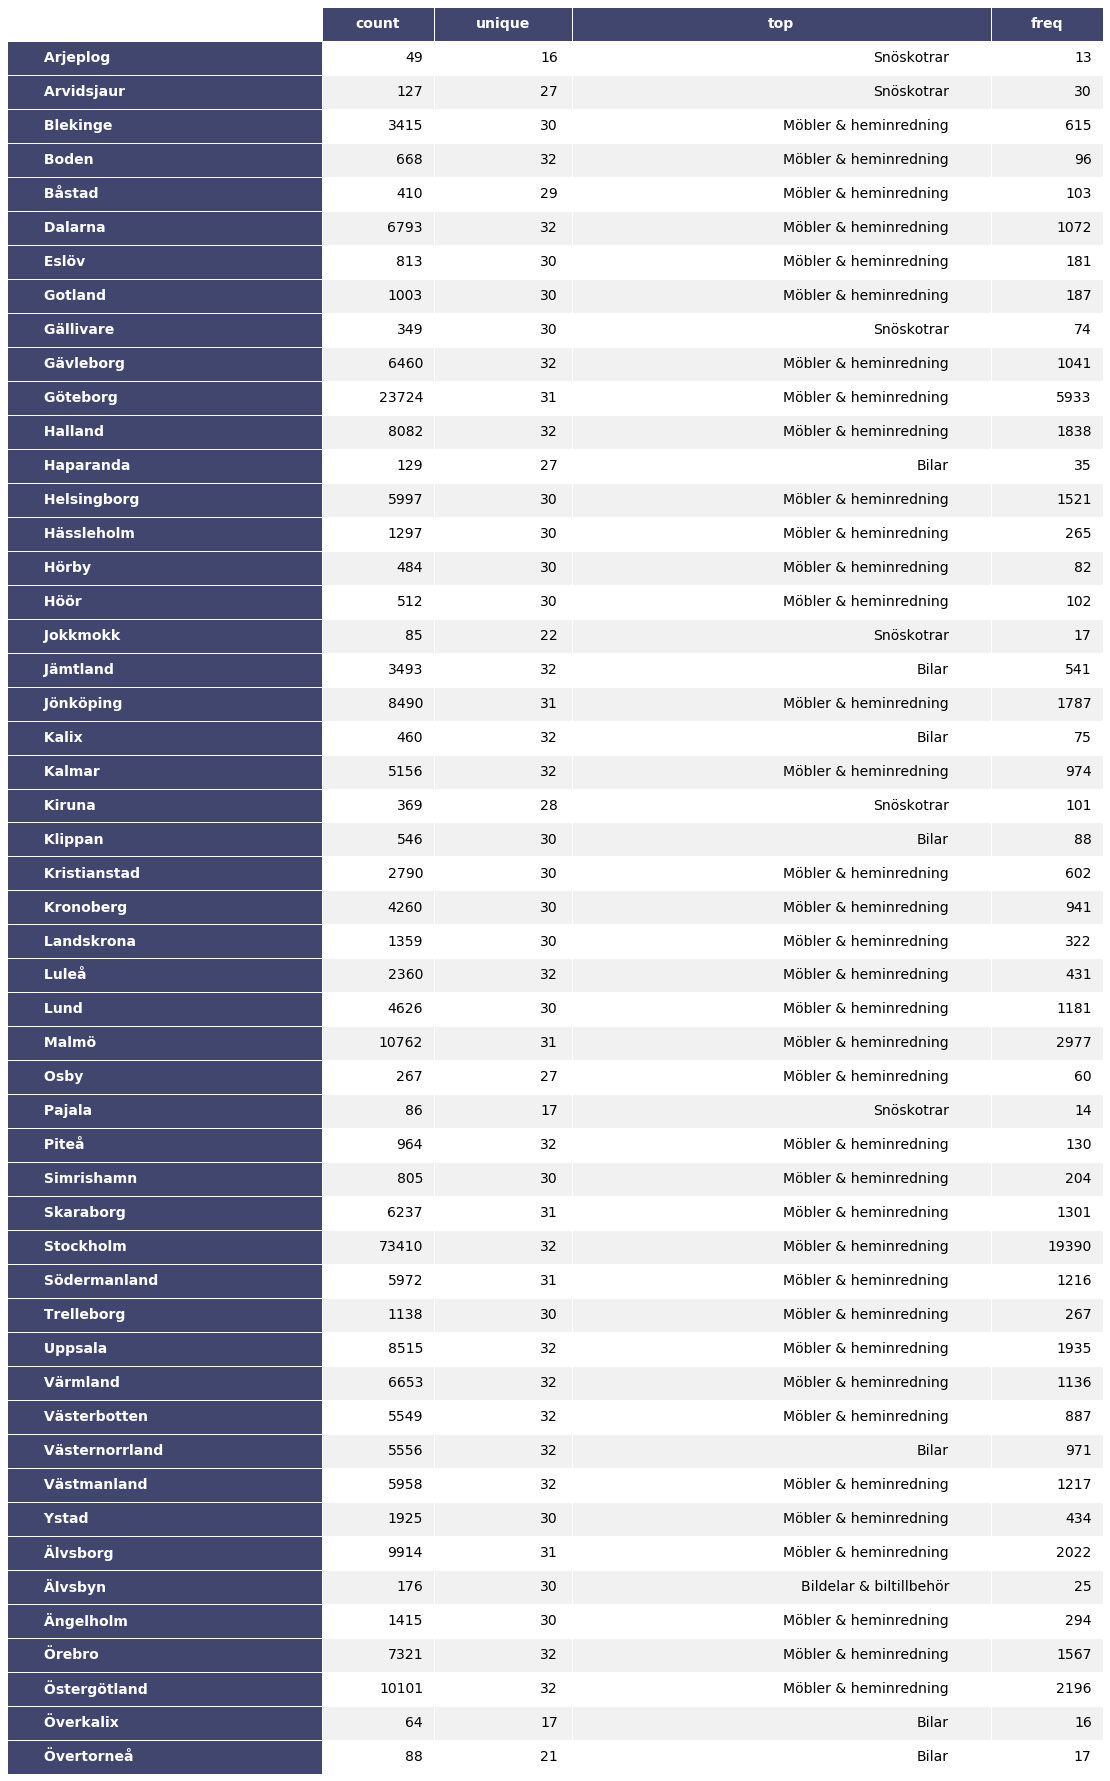

In [65]:
fig = render_mpl_table(df_category_by_region, header_columns=0, col_width=3.0, index_col_width=2.0).get_figure()
fig.savefig('tables/category_by_region.png', bbox_inches = "tight")

Describing Price by Category:

In [66]:
df_price_by_category = df.groupby('Category')['Price'].describe()

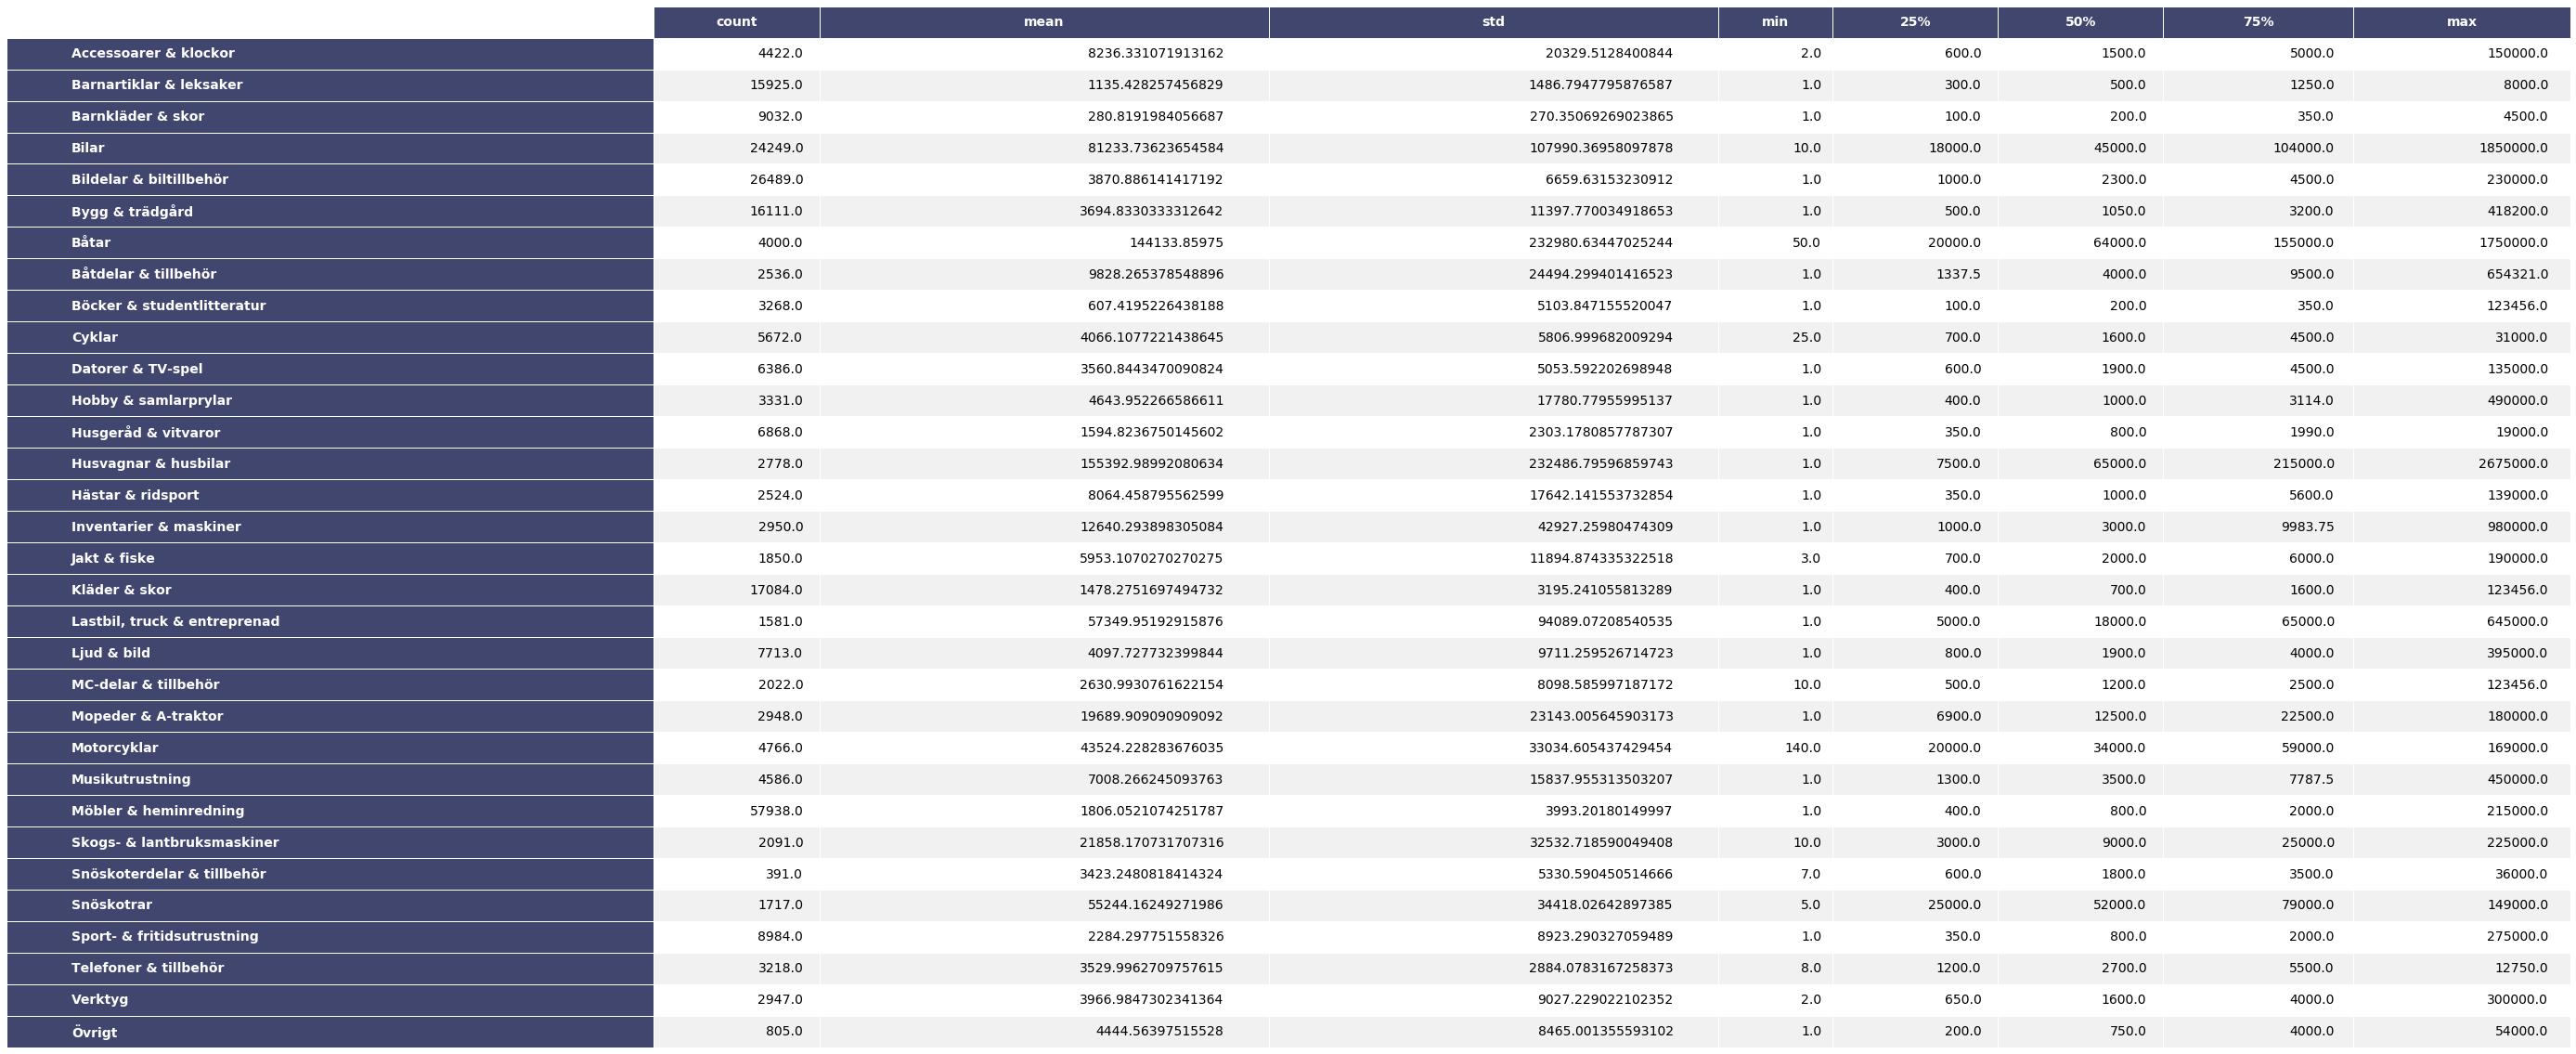

In [67]:
fig = render_mpl_table(df_price_by_category, header_columns=0, col_width=4.0, index_col_width=5.0).get_figure()
fig.savefig('tables/price_by_category.png', bbox_inches = "tight")

Describing Telefoner & tillbehör by Region:

In [44]:
df.loc[df['Category'] == 'Telefoner & tillbehör'].groupby('Region').describe()

Price                                                     \
                  count         mean          std     min      25%     50%   
Region                                                                       
 Arvidsjaur         1.0  4800.000000          NaN  4800.0  4800.00  4800.0   
 Blekinge          37.0  3349.891892  2806.488531   149.0  1200.00  3000.0   
 Boden              4.0  6822.500000  2390.542128  3500.0  5975.00  7395.0   
 Dalarna           60.0  3932.316667  2739.379303   150.0  1300.00  3450.0   
 Eslöv              7.0  1450.000000   700.594985   400.0  1225.00  1500.0   
 Gotland           10.0  3730.000000  2307.499850  1000.0  1775.00  3500.0   
 Gällivare          2.0  2850.000000  3747.665940   200.0  1525.00  2850.0   
 Gävleborg         57.0  3259.105263  2835.942384    50.0  1000.00  2500.0   
 Göteborg         333.0  3956.984985  3115.551783    40.0  1100.00  3000.0   
 Halland           78.0  2896.525641  2597.835436    49.0  1000.00  1850.0   
 Haparanda          1.0  1000.000000          NaN  1000.0  1000.00  1000.0   
 Helsingborg      107.0  3275.028037  3021.803483    49.0   825.00  1900.0   
 Hässleholm        18.0  2907.777778  2631.098083   300.0  1047.50  2000.0   
 Hörby              8.0  1743.125000   877.142021   600.0  1312.50  1600.0   
 Höör               4.0  2880.000000  3360.545591    70.0   580.00  1975.0   
 Jokkmokk           1.0  9000.000000          NaN  9000.0  9000.00  9000.0   
 Jämtland          20.0  1792.450000  2098.490196   100.0   650.00  1000.0   
 Jönköping         95.0  3579.284211  2645.643978    50.0  1500.00  2900.0   
 Kalix              6.0  3041.666667  2150.445690   600.0  1187.50  3200.0   
 Kalmar            89.0  2870.842697  2240.918698    20.0  1200.00  2000.0   
 Kiruna             3.0  1666.666667  1301.281420   400.0  1000.00  1600.0   
 Klippan            6.0  4366.500000  2795.734877   699.0  2175.00  4900.0   
 Kristianstad      38.0  3143.078947  2603.900830    99.0  1200.00  2250.0   
 Kronoberg         51.0  3482.313725  2972.395529    75.0  1500.00  2500.0   
 Landskrona        19.0  2688.421053  2673.417004    30.0   350.00  1900.0   
 Luleå             24.0  3428.750000  2635.066722    40.0  1500.00  3500.0   
 Lund              60.0  2647.166667  2335.472290   150.0   800.00  1900.0   
 Malmö            206.0  4121.582524  2993.481862     8.0  1600.00  3500.0   
 Osby               3.0  1766.666667  1123.981020   800.0  1150.00  1500.0   
 Piteå             10.0  3685.000000  2237.316100   250.0  3075.00  3750.0   
 Simrishamn         9.0  1496.666667  1783.704011    20.0   500.00   800.0   
 Skaraborg         67.0  3376.074627  2771.374374   100.0  1300.00  2500.0   
 Stockholm       1011.0  3570.380811  2923.710922    20.0  1100.00  2790.0   
 Södermanland      71.0  3267.098592  2992.250630    50.0   720.00  2000.0   
 Trelleborg        12.0  4699.916667  2834.591536   800.0  2574.25  3950.0   
 Uppsala          109.0  3568.440367  2875.540472    30.0  1200.00  2500.0   
 Värmland          66.0  4151.469697  3284.462163   160.0  1562.50  3500.0   
 Västerbotten      45.0  3732.000000  3161.596691   200.0  1000.00  2500.0   
 Västernorrland    54.0  4295.907407  2607.702294   140.0  2000.00  4250.0   
 Västmanland       58.0  3865.551724  2857.902557   150.0  1625.00  2900.0   
 Ystad             17.0  2461.705882  2353.072081   350.0   500.00  1500.0   
 Älvsborg         106.0  3165.018868  2840.887169    99.0  1000.00  2500.0   
 Ängelholm         15.0  3896.666667  2210.241314   350.0  2400.00  3200.0   
 Örebro            86.0  3404.965116  2802.607573    50.0  1125.00  2800.0   
 Östergötland     132.0  3237.492424  2862.504216    45.0  1000.00  2300.0   
 Övertorneå         2.0  2400.000000  2687.005769   500.0  1450.00  2400.0   

                                   
                     75%      max  
Region                             
 Arvidsjaur      4800.00   4800.0  
 Blekinge        4000.00  10000.0  
 Boden         

Describing Möbler & heminredning by Region:

In [45]:
df.loc[df['Category'] == 'Möbler & heminredning'].groupby('Region').describe()

Price                                                      \
                   count         mean           std     min      25%     50%   
Region                                                                         
 Arjeplog            2.0  1500.000000    707.106781  1000.0  1250.00  1500.0   
 Arvidsjaur          4.0   525.000000    317.542648   350.0   350.00   375.0   
 Blekinge          615.0  1533.432520   2786.972522    10.0   400.00   800.0   
 Boden              96.0  1364.520833   2119.869470    25.0   250.00   550.0   
 Båstad            103.0  1637.135922   2792.158979    50.0   200.00   500.0   
 Dalarna          1072.0  1570.050373   2343.248451     1.0   350.00   700.0   
 Eslöv             181.0  2997.917127  10246.932849     1.0   400.00   850.0   
 Gotland           187.0  2252.010695   9176.301212    50.0   395.00   700.0   
 Gällivare          30.0  2571.666667   3362.282767    50.0   500.00   900.0   
 Gävleborg        1041.0  1725.761768   2680.643288     5.0   400.00   800.0   
 Göteborg         5933.0  1773.236643   3650.969756     1.0   400.00   800.0   
 Halland          1838.0  1670.031012   2982.930901     1.0   400.00   800.0   
 Haparanda          14.0  1487.500000   1651.012219   100.0   212.50   800.0   
 Helsingborg      1521.0  2016.693623   3431.170909     1.0   400.00   900.0   
 Hässleholm        265.0  1626.339623   2265.009197    40.0   400.00   750.0   
 Hörby              82.0  1513.865854   3299.904962    20.0   312.50   712.5   
 Höör              102.0   811.764706    896.992954    50.0   212.50   500.0   
 Jokkmokk            2.0   525.000000    318.198052   300.0   412.50   525.0   
 Jämtland          447.0  2118.109620   8481.742368     8.0   350.00   800.0   
 Jönköping        1787.0  1726.291550   2773.809096    10.0   400.00   800.0   
 Kalix              60.0  1905.500000   2898.094304    50.0   325.00   600.0   
 Kalmar            974.0  1854.345996   6536.414369    10.0   400.00   800.0   
 Kiruna             11.0  3986.363636   5823.533760   150.0   375.00   800.0   
 Klippan            87.0  1569.413793   3462.037999    50.0   350.00   700.0   
 Kristianstad      602.0  1923.554817   5833.617844     1.0   400.00   800.0   
 Kronoberg         941.0  1733.121148   4661.427378     2.0   400.00   800.0   
 Landskrona        322.0  1898.869565   3127.894743    40.0   400.00   800.0   
 Luleå             431.0  1586.426914   6191.193363    15.0   300.00   600.0   
 Lund             1181.0  1617.986452   3109.535961     3.0   300.00   600.0   
 Malmö            2977.0  1979.830030   4212.697695     1.0   400.00   800.0   
 Osby               60.0  1637.583333   2459.908447    80.0   400.00   800.0   
 Pajala              9.0   877.777778   1188.252685   200.0   300.00   600.0   
 Piteå             130.0  1958.846154   2883.597394   100.0   400.00   825.0   
 Simrishamn        204.0  2135.367647   8728.891604    40.0   400.00   974.5   
 Skaraborg        1301.0  1680.800154   2849.457755    10.0   400.00   800.0   
 Stockholm       19390.0  1893.244662   4066.934163     1.0   400.00   800.0   
 Södermanland     1216.0  1883.936678   2815.812292    10.0   500.00  1000.0   
 Trelleborg        267.0  1846.198502   2932.257942    20.0   487.00   900.0   
 Uppsala          1935.0  1709.730233   4684.464906     1.0   350.00   750.0   
 Värmland         1136.0  1709.227993   3489.000223    10.0   400.00   700.0   
 Västerbotten      887.0  1591.439684   4778.880104    10.0   400.00   650.0   
 Västernorrland    738.0  1855.789973   4163.686977     1.0   400.00   800.0   
 Västmanland      1217.0  1573.555464   2239.681065    10.0   350.00   750.0   
 Ystad             434.0  2028.235023   7648.434256    10.0   400.00   750.0   
 Älvsborg         2022.0  1627.410979   2471.747603     1.0   400.00   800.0   
 Älvsbyn            19.0  1371.263158   2026.782695    20.0   325.00   800.0   
 Ängelholm         294.0  1892.370748   2637.577487     1.0   461.25   900.0   
 Örebro           1

### Pie chart - products by category

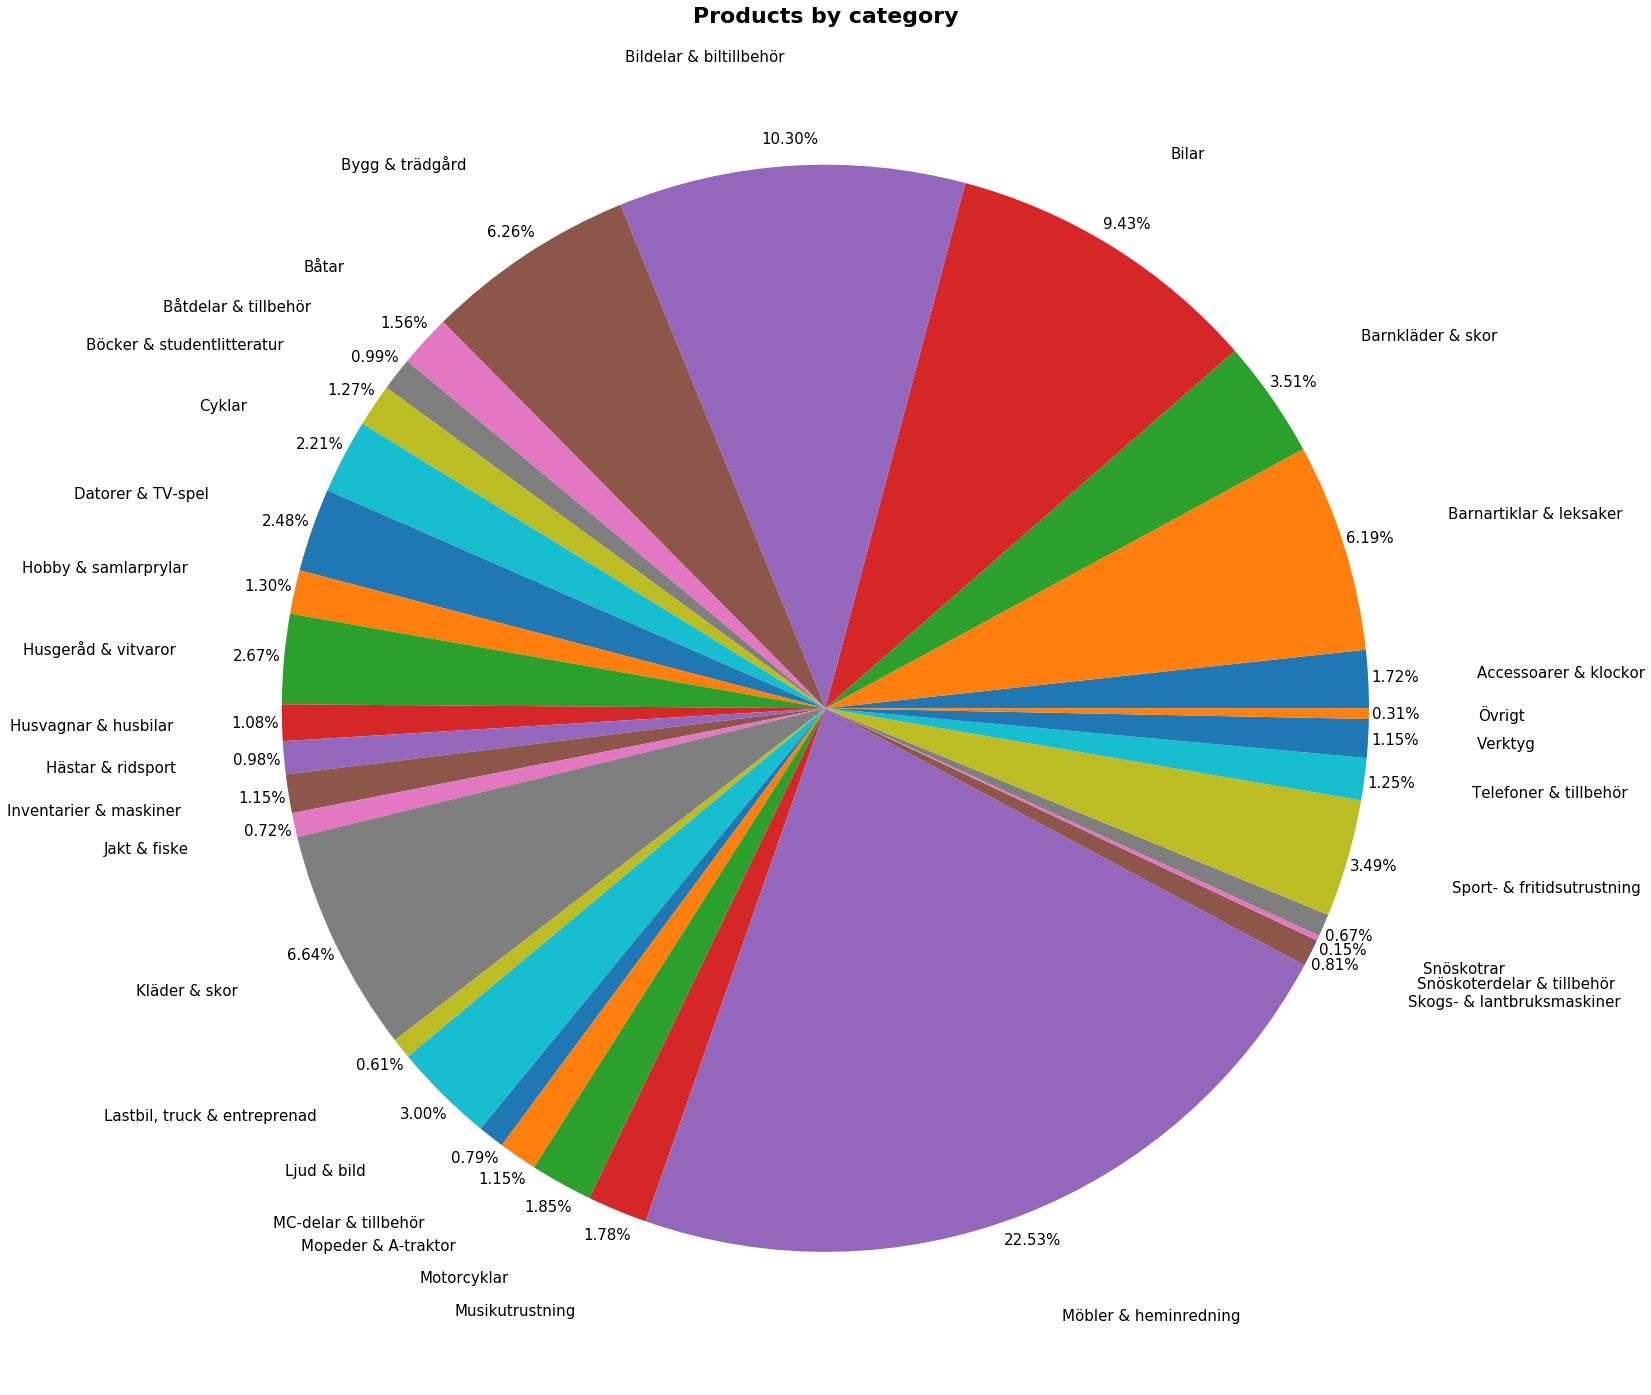

In [46]:
df.groupby(['Category']).size().plot(kind='pie', subplots=True, autopct='%1.2f%%', figsize=(25, 25), fontsize="15", pctdistance=1.05, labeldistance=1.2)
plt.title("Products by category", fontweight="bold", fontsize="22")
plt.ylabel('')
plt.savefig('charts/pie chart_products by category.jpg') 
plt.show()

### Bar chart - products by region and category

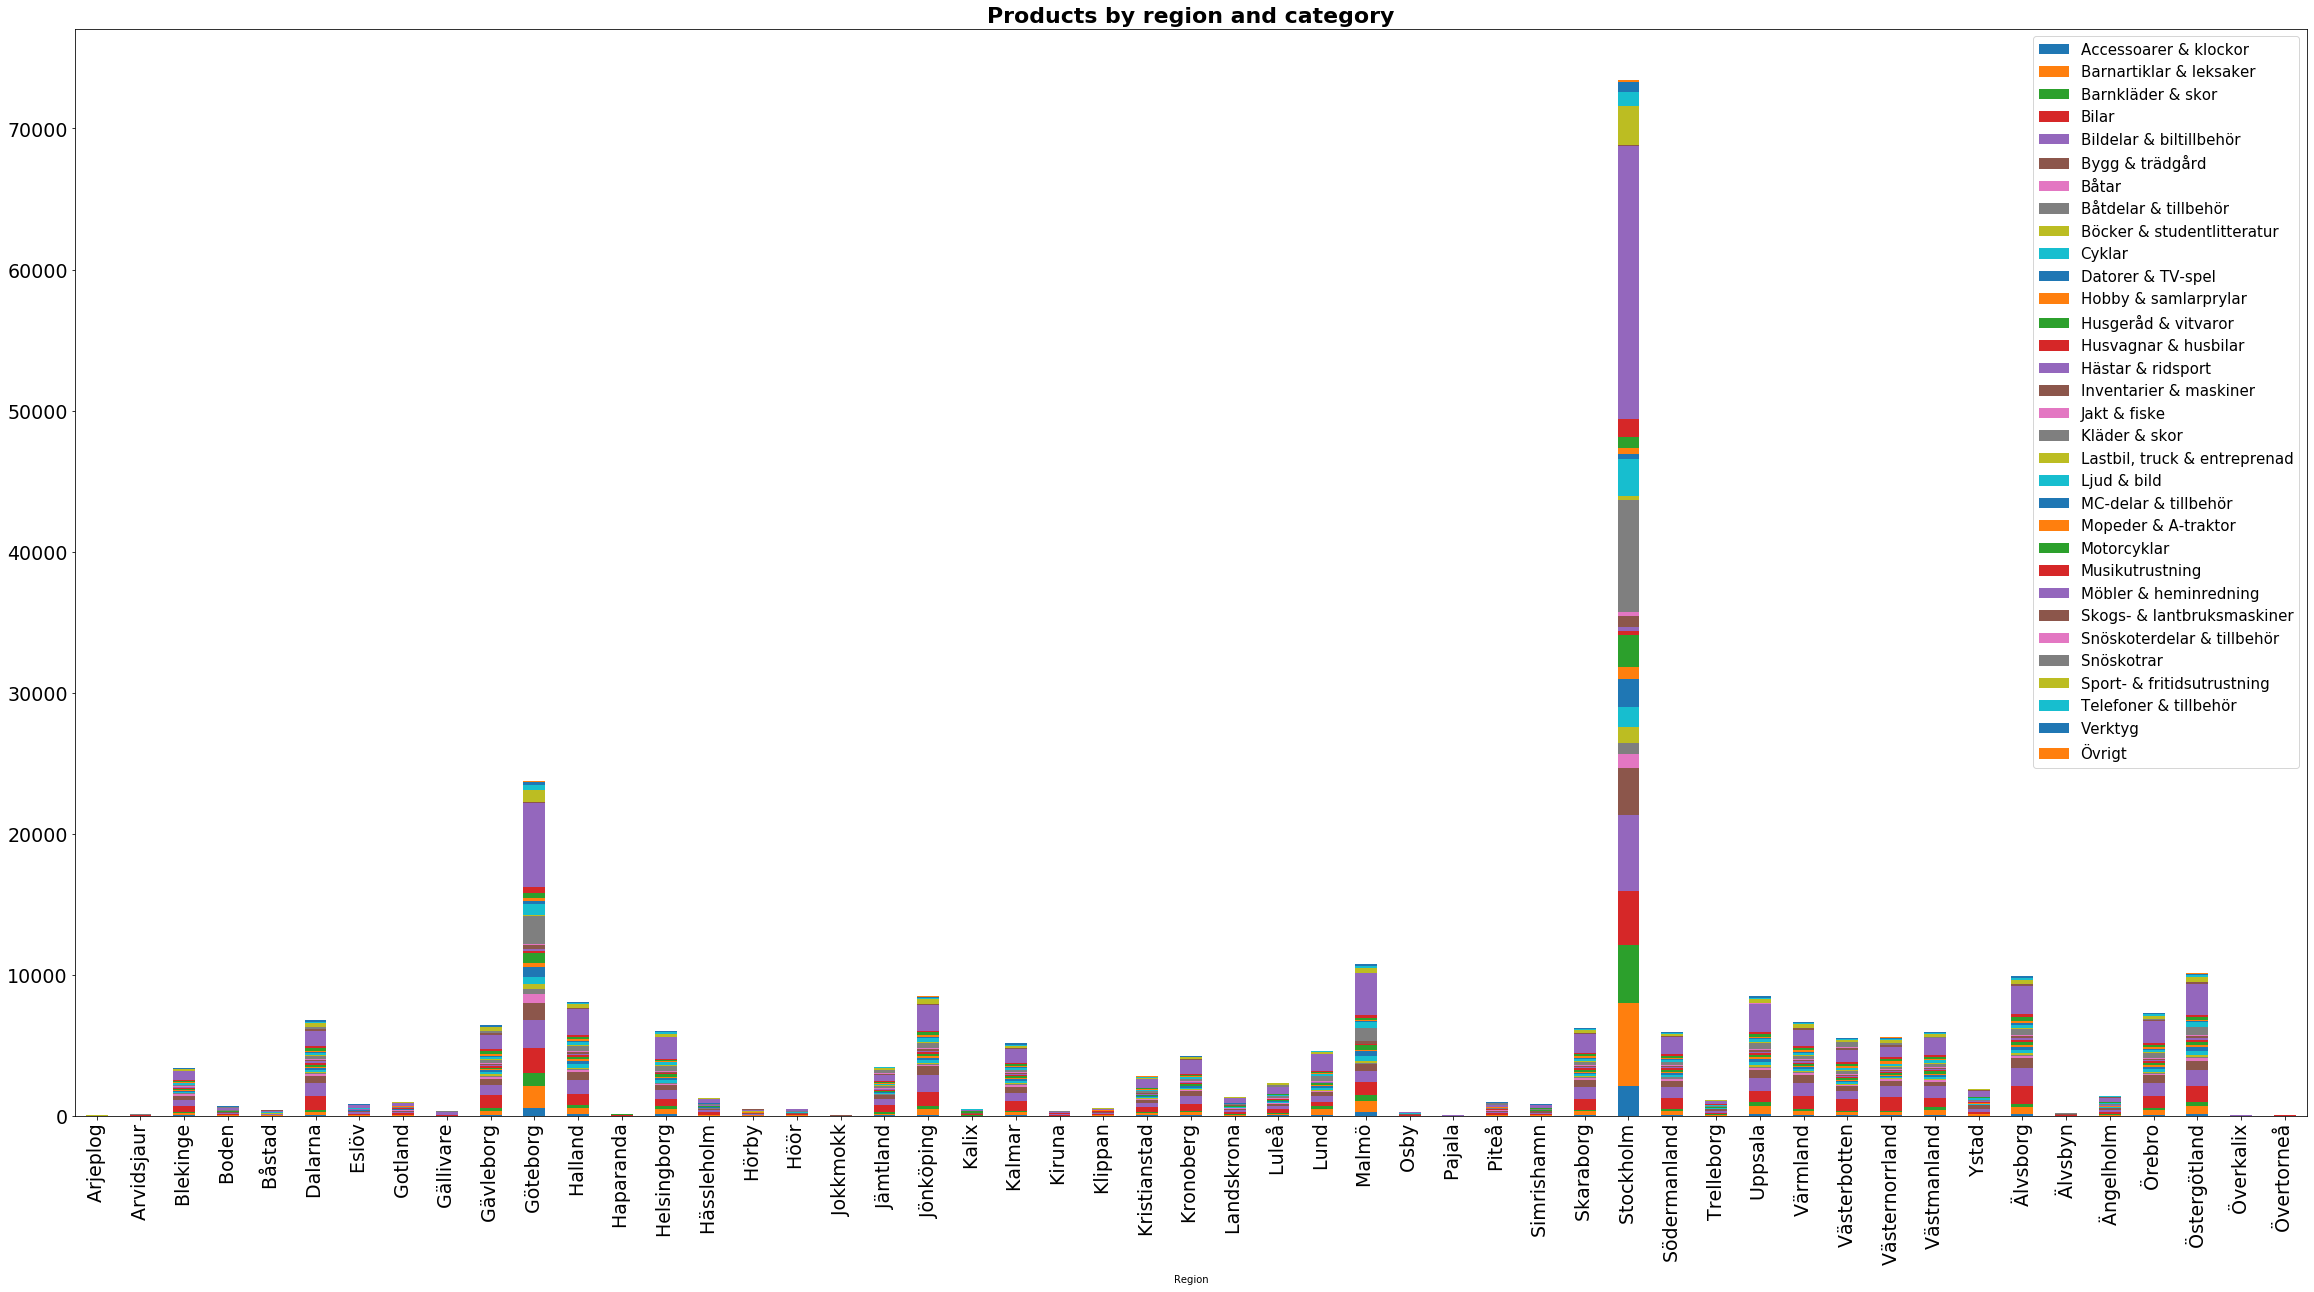

In [47]:
df.groupby(['Region','Category']).size().unstack().plot(kind='bar', stacked=True, figsize=(40,20), fontsize="19")
plt.title("Products by region and category", fontweight="bold", fontsize="22")
plt.legend(prop={'size':15})
plt.savefig('charts/bar chart_products by region and category.jpg') 
plt.show()

### Normalized bar chart - products by region and category

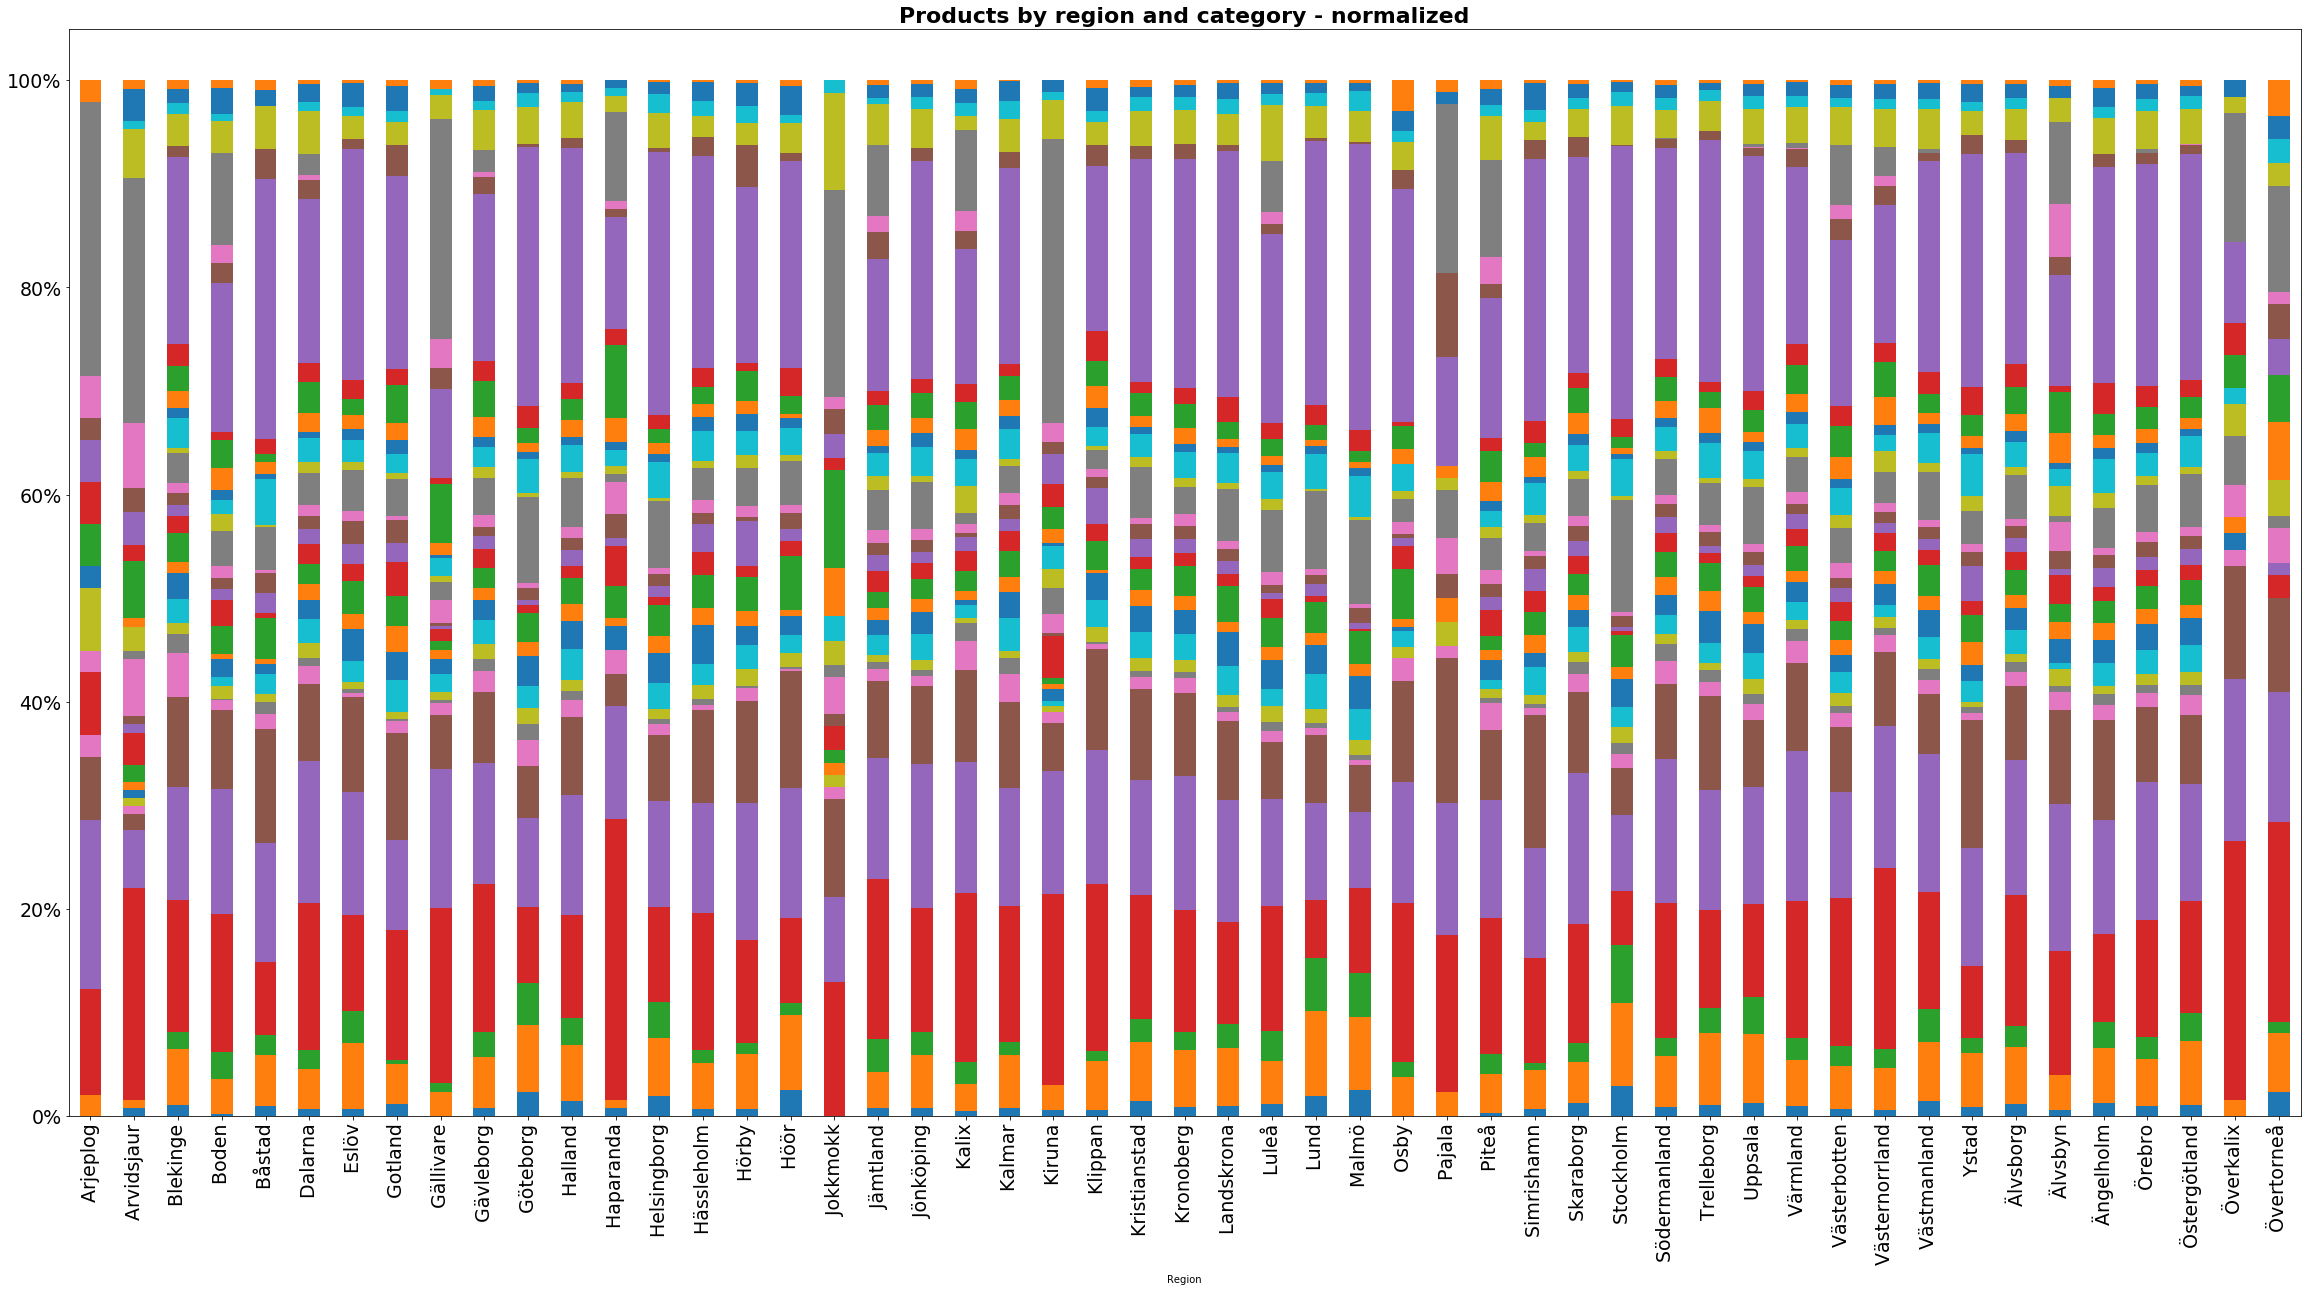

In [48]:
df.groupby(['Region','Category']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar', stacked=True, figsize=(40,20), fontsize="19", legend=None)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Products by region and category - normalized", fontweight="bold", fontsize="22")
plt.savefig('charts/normalized bar chart_products by region and category.jpg') 
plt.show()

# Potential environmental benefit

## Selecting one representative product per category

Selecting the products with the closest price to the price average of each category:

In [49]:
df_selected_products = pd.DataFrame(columns=df.columns)

for category in df['Category'].unique().tolist():   
    
    df_category = df.loc[df['Category'] == category].copy() 
    mean_category = df_category['Price'].mean()
    df_selected_products = df_selected_products.append(df_category.iloc[(df_category['Price']-mean_category).abs().argsort()[:1]])
    
df_selected_products = df_selected_products.sort_values(by ='Category')   

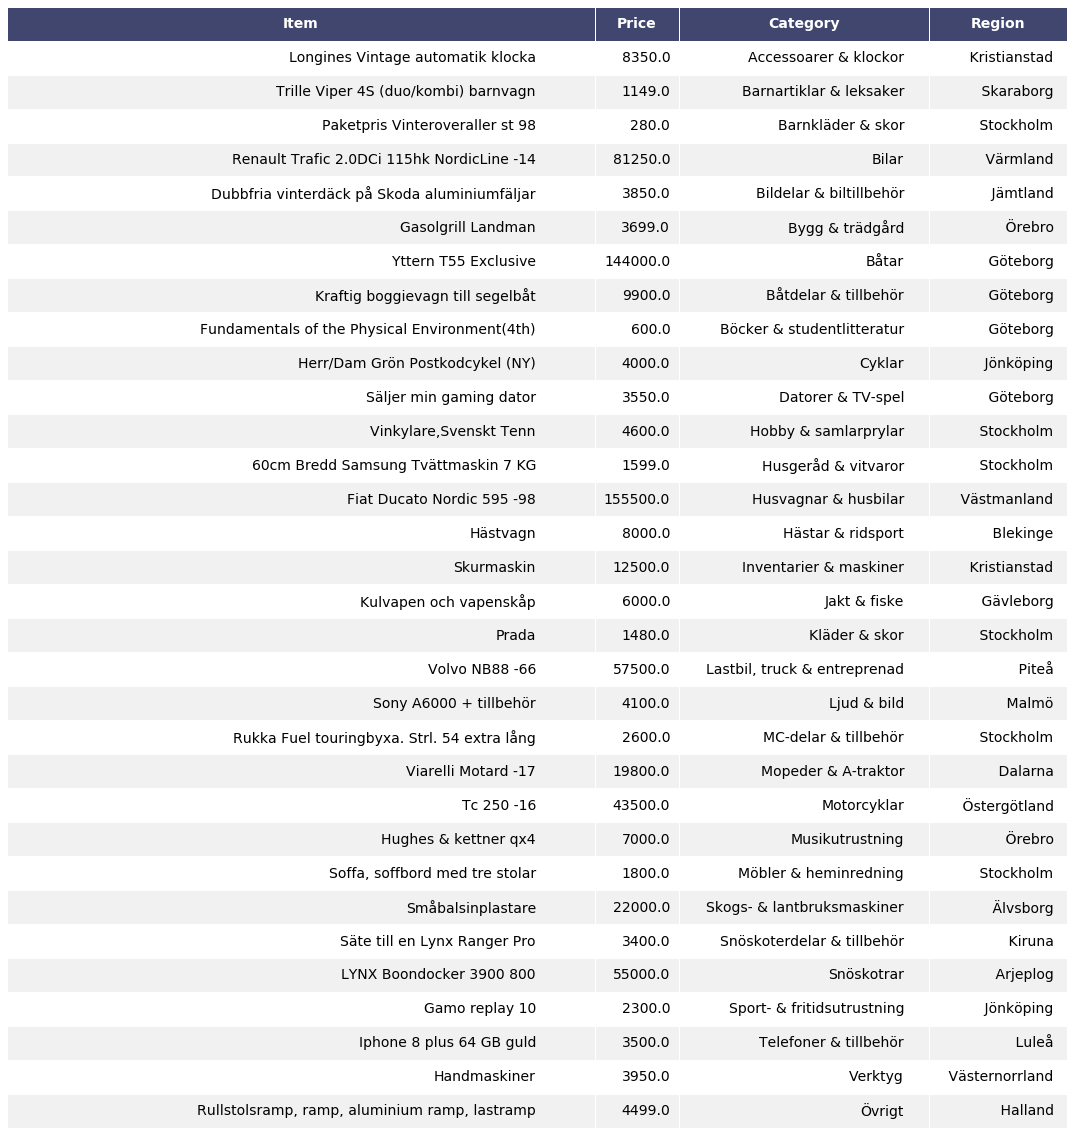

In [50]:
fig = render_mpl_table(df_selected_products, header_columns=0, col_width=4.0, index='no').get_figure()
fig.savefig('tables/selected_products.png')

## Determining the respective price of equivalent new products

Web scraping the price of new products from Google Shopping by searching for the selected items:

In [70]:
df_price_comparison = df_selected_products.copy()
average_prices_of_new_items = []
sources = []
 
url = 'https://www.google.com/search?tbm=shop&hl=en-SE&q='
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.70 Safari/13.0.3 '}
    
for item, price_used_item in zip(df_selected_products['Item'].tolist(), df_selected_products['Price'].tolist()):
    
    item_url = item.replace(" ", "%20")
    search_url = url + item_url
    
    print(search_url)  

    response = requests.get(search_url, headers=headers)    
    try:    
        response.raise_for_status() 
    except Exception as exc:    
         print('There was a problem: %s' % (exc))

    soup = BeautifulSoup(response.text, "html.parser")

    all_prices = soup.find_all("div", ['sh-dlr__content','sh-dgr__offer-content'])    
    
    sum = 0.0       
    number_of_new_products = 0
    
    for one_price in all_prices:    
    
        price_span = one_price.find('span', attrs={'class': 'Nr22bf'})       
        is_used = one_price.find('span', attrs={'class': 'EtARAd'})        
        if is_used is None:        
            price_new_item = float(price_span.text.strip().split("kr", 1)[0].replace("kr", "").replace(".", "").replace(u'\xa0', ' ').replace(",", ".").replace(" ", ""))   
                        
            if (price_new_item > price_used_item):            
                sum = sum + price_new_item
                number_of_new_products = number_of_new_products + 1            
    
    if number_of_new_products != 0:
        average_price_of_new_item = sum/number_of_new_products
        source = "(Google Shopping, 2020)"
    else:
        average_price_of_new_item = 0 
        source = ""
    
    average_prices_of_new_items.append(average_price_of_new_item)
    sources.append(source)
    
    #print(average_price_of_new_item)    

https://www.google.com/search?tbm=shop&hl=en-SE&q=Longines%20Vintage%20automatik%20klocka
https://www.google.com/search?tbm=shop&hl=en-SE&q=Trille%20Viper%204S%20(duo/kombi)%20barnvagn
https://www.google.com/search?tbm=shop&hl=en-SE&q=Paketpris%20Vinteroveraller%20st%2098
https://www.google.com/search?tbm=shop&hl=en-SE&q=Renault%20Trafic%202.0DCi%20115hk%20NordicLine%20-14
https://www.google.com/search?tbm=shop&hl=en-SE&q=Dubbfria%20vinterdäck%20på%20Skoda%20aluminiumfäljar
https://www.google.com/search?tbm=shop&hl=en-SE&q=Gasolgrill%20Landman
https://www.google.com/search?tbm=shop&hl=en-SE&q=Yttern%20T55%20Exclusive
https://www.google.com/search?tbm=shop&hl=en-SE&q=Kraftig%20boggievagn%20till%20segelbåt
https://www.google.com/search?tbm=shop&hl=en-SE&q=Fundamentals%20of%20the%20Physical%20Environment(4th)
https://www.google.com/search?tbm=shop&hl=en-SE&q=Herr/Dam%20Grön%20Postkodcykel%20(NY)
https://www.google.com/search?tbm=shop&hl=en-SE&q=Säljer%20min%20gaming%20dator
https://www.go

In [71]:
idx=2
df_price_comparison.insert(loc=idx, column='Source (price new product)', value=sources)
df_price_comparison.insert(loc=idx, column='Price new product [kr]', value=average_prices_of_new_items)
df_price_comparison = df_price_comparison.drop(['Region'], axis=1)
df_price_comparison = df_price_comparison.rename(columns={'Price': 'Price used product [kr]'}) 

In [72]:
df_price_comparison.to_csv('saved_dataframes/df_price_comparison_scraped_data.csv', index=False)
df_price_comparison.style.hide_index()

Item,Price used product [kr],Price new product [kr],Source (price new product),Category
Longines Vintage automatik klocka,8350,21742,"(Google Shopping, 2020)",Accessoarer & klockor
Trille Viper 4S (duo/kombi) barnvagn,1149,4699,"(Google Shopping, 2020)",Barnartiklar & leksaker
Paketpris Vinteroveraller st 98,280,778.146,"(Google Shopping, 2020)",Barnkläder & skor
Renault Trafic 2.0DCi 115hk NordicLine -14,81250,0,,Bilar
Dubbfria vinterdäck på Skoda aluminiumfäljar,3850,3957,"(Google Shopping, 2020)",Bildelar & biltillbehör
Gasolgrill Landman,3699,6601.35,"(Google Shopping, 2020)",Bygg & trädgård
Yttern T55 Exclusive,144000,0,,Båtar
Kraftig boggievagn till segelbåt,9900,31055.8,"(Google Shopping, 2020)",Båtdelar & tillbehör
Fundamentals of the Physical Environment(4th),600,864.294,"(Google Shopping, 2020)",Böcker & studentlitteratur
Herr/Dam Grön Postkodcykel (NY),4000,4995,"(Google Shopping, 2020)",Cyklar


Manually inserting the missing prices:

In [73]:
df_price_comparison = pd.read_csv('saved_dataframes/df_price_comparison_scraped_data.csv')

# https://www.renault.se/bilar/kampanj-lcv/trafic.html?&ds_rl=1251782&gclid=EAIaIQobChMI-ez8vaCQ5wIVhoeyCh3ahgEsEAAYASAAEgJZkfD_BwE&gclsrc=aw.ds
df_price_comparison.loc[df_price_comparison['Item']=='Renault Trafic 2.0DCi 115hk NordicLine -14', 'Source (price new product)'] =  '(Renault Sverige, 2020)'
df_price_comparison.loc[df_price_comparison['Item']=='Renault Trafic 2.0DCi 115hk NordicLine -14', 'Price new product [kr]'] = 209500.0 

# https://skodatillbehor.se/Product/SEWA07521
df_price_comparison.loc[df_price_comparison['Item']=='Dubbfria vinterdäck på Skoda aluminiumfäljar', 'Source (price new product)'] =  '(SkodaTillbehör, 2019)'
df_price_comparison.loc[df_price_comparison['Item']=='Dubbfria vinterdäck på Skoda aluminiumfäljar', 'Price new product [kr]'] = 3459.0*4 

# https://www.sokbat.se/Motorbatar/UTTERN/Modell/Nyhet-uttern-t59/57308
df_price_comparison.loc[df_price_comparison['Item']=='Yttern T55 Exclusive', 'Source (price new product)'] =  '(Sweboat – Båtbranschens Riksförbund, 2020)'
df_price_comparison.loc[df_price_comparison['Item']=='Yttern T55 Exclusive', 'Price new product [kr]'] = 419900.0

# https://www.fiatprofessional.com/se/erbjudanden/erbjudanden.ducato-volymskap
df_price_comparison.loc[df_price_comparison['Item']=='Fiat Ducato Nordic 595 -98', 'Source (price new product)'] =  '(Fiat Professional, 2020)'
df_price_comparison.loc[df_price_comparison['Item']=='Fiat Ducato Nordic 595 -98', 'Price new product [kr]'] = 355700.0

# https://carriagedrivingnordic.se/produkt/slg/
df_price_comparison.loc[df_price_comparison['Item']=='Hästvagn', 'Source (price new product)'] =  '(Carriage Driving Nordic AB, 2018)'
df_price_comparison.loc[df_price_comparison['Item']=='Hästvagn', 'Price new product [kr]'] = 16500.0

# https://bilweb.se/blekinge-lan/volvo-fh-16-fl280-4x2-bargningsbil-16-tons-chassi-2019-personbil-6395649
df_price_comparison.loc[df_price_comparison['Item']=='Volvo NB88 -66', 'Source (price new product)'] =  '(Bilweb, 2020)'
df_price_comparison.loc[df_price_comparison['Item']=='Volvo NB88 -66', 'Price new product [kr]'] = 1868750.0

# https://motorsweden.se/moped-viarelli-motard-klass-1
df_price_comparison.loc[df_price_comparison['Item']=='Viarelli Motard -17', 'Source (price new product)'] =  '(Motorsweden, 2020)'
df_price_comparison.loc[df_price_comparison['Item']=='Viarelli Motard -17', 'Price new product [kr]'] = 27990.0

# https://www.husqvarna-motorcycles.com/se/motocross/2-stroke/tc-250/
df_price_comparison.loc[df_price_comparison['Item']=='Tc 250 -16', 'Source (price new product)'] =  '(Husqvarna Motorcycles, 2020)'
df_price_comparison.loc[df_price_comparison['Item']=='Tc 250 -16', 'Price new product [kr]'] = 85900.0

# https://cngooler.en.made-in-china.com/product/cSuniDEHnwhd/China-Hw0810-Mini-Round-Hay-Straw-Silage-Bale-Wrapper-Gasoline-Petrol-Engine-Bale-Wrapper.html
df_price_comparison.loc[df_price_comparison['Item']=='Småbalsinplastare', 'Source (price new product)'] =  '(Gooler International Group Co. Ltd., 2020)'
df_price_comparison.loc[df_price_comparison['Item']=='Småbalsinplastare', 'Price new product [kr]'] = 1280.0*USD_TO_SEK

# https://www.stenmarksmaskin.se/lynx-boondocker-3900-ds-800-e-tec    
df_price_comparison.loc[df_price_comparison['Item']=='LYNX Boondocker 3900 800', 'Source (price new product)'] =  '(Stenmarks Maskin, 2020)'
df_price_comparison.loc[df_price_comparison['Item']=='LYNX Boondocker 3900 800', 'Price new product [kr]'] = 145900.0

# https://www.olssonsfiske.se/knivar-luftvapen/luftvapen/gamo-replay-10-4-5mm-m-4x32-sikte
df_price_comparison.loc[df_price_comparison['Item']=='Gamo replay 10', 'Source (price new product)'] =  '(Olssons Fiske, 2020)'
df_price_comparison.loc[df_price_comparison['Item']=='Gamo replay 10', 'Price new product [kr]'] = 3199.0

df_price_comparison.to_csv('saved_dataframes/df_price_comparison_complete_data.csv', index=False)
df_price_comparison.style.hide_index()

Item,Price used product [kr],Price new product [kr],Source (price new product),Category
Longines Vintage automatik klocka,8350,21742,"(Google Shopping, 2020)",Accessoarer & klockor
Trille Viper 4S (duo/kombi) barnvagn,1149,4699,"(Google Shopping, 2020)",Barnartiklar & leksaker
Paketpris Vinteroveraller st 98,280,778.146,"(Google Shopping, 2020)",Barnkläder & skor
Renault Trafic 2.0DCi 115hk NordicLine -14,81250,209500,"(Renault Sverige, 2020)",Bilar
Dubbfria vinterdäck på Skoda aluminiumfäljar,3850,13836,"(SkodaTillbehör, 2019)",Bildelar & biltillbehör
Gasolgrill Landman,3699,6601.35,"(Google Shopping, 2020)",Bygg & trädgård
Yttern T55 Exclusive,144000,419900,"(Sweboat – Båtbranschens Riksförbund, 2020)",Båtar
Kraftig boggievagn till segelbåt,9900,31055.8,"(Google Shopping, 2020)",Båtdelar & tillbehör
Fundamentals of the Physical Environment(4th),600,864.294,"(Google Shopping, 2020)",Böcker & studentlitteratur
Herr/Dam Grön Postkodcykel (NY),4000,4995,"(Google Shopping, 2020)",Cyklar


## Calculating the carbon footprint per consumption category for Sweden 

In [13]:
#download the EXIOBASE 3.4 - IOT - 2011 - pxp
#from: https://exiobase.eu/index.php/data-download/exiobase3mon
#import database
#see https://pymrio.readthedocs.io/en/latest/index.html
exio3 = pymrio.parse_exiobase3('C:\\Users\\keseljoa\\Desktop\\IOT\\IOT_2011_pxp')

In [14]:
#calculate missing dataframes
exio3.calc_all()

In [15]:
#chatacterisation factors to convert environmemtal stressors into footprints
characterization = pd.read_csv('characterization_factors\\EXIOBASE341f_CC500f.csv',',', header=[0], index_col = [0])

In [16]:
M_SE = exio3.satellite.M.SE.T

In [17]:
df1 = characterization.copy()
df2 = M_SE.copy()

characterization = df1.drop([idx for idx in df1.index if idx in df1.index and idx not in df2.columns], axis=0)
M_SE = df2.drop([col for col in df2.columns if col in df2.columns and col not in df1.index], axis=1)

In [18]:
M_SE_footprints = M_SE.dot(characterization)

In [19]:
M_SE_footprints.to_excel(r'saved_dataframes/footprints_SE.xlsx')

## Determining the carbon footprints of the new products

In [20]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

from collections import defaultdict

df_carbon_emissions = pd.read_csv(r'saved_dataframes/df_price_comparison_complete_data.csv')
footprints_SE = M_SE_footprints.copy()

footprints = defaultdict(list)
industries = []
products_footprints = []

footprints['Longines Vintage automatik klocka'].append(['Medical, precision and optical instruments, watches and clocks (33)',  footprints_SE.loc['Medical, precision and optical instruments, watches and clocks (33)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Trille Viper 4S (duo/kombi) barnvagn'].append(['Other transport equipment (35)', footprints_SE.loc['Other transport equipment (35)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Paketpris Vinteroveraller st 98'].append(['Wearing apparel; furs (18)', footprints_SE.loc['Wearing apparel; furs (18)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Renault Trafic 2.0DCi 115hk NordicLine -14'].append(['Motor vehicles, trailers and semi-trailers (34)', footprints_SE.loc['Motor vehicles, trailers and semi-trailers (34)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Dubbfria vinterdäck på Skoda aluminiumfäljar'].append(['Other transport equipment (35)', footprints_SE.loc['Other transport equipment (35)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Gasolgrill Landman'].append(['Electrical machinery and apparatus n.e.c. (31)', footprints_SE.loc['Electrical machinery and apparatus n.e.c. (31)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Yttern T55 Exclusive'].append(['Motor vehicles, trailers and semi-trailers (34)', footprints_SE.loc['Motor vehicles, trailers and semi-trailers (34)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Kraftig boggievagn till segelbåt'].append(['Other transport equipment (35)', footprints_SE.loc['Other transport equipment (35)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Fundamentals of the Physical Environment(4th)'].append(['Printed matter and recorded media (22)', footprints_SE.loc['Printed matter and recorded media (22)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Herr/Dam Grön Postkodcykel (NY)'].append(['Other transport equipment (35)', footprints_SE.loc['Other transport equipment (35)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Säljer min gaming dator'].append(['Office machinery and computers (30)', footprints_SE.loc['Office machinery and computers (30)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Vinkylare,Svenskt Tenn'].append(['Furniture; other manufactured goods n.e.c. (36)', footprints_SE.loc['Furniture; other manufactured goods n.e.c. (36)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['60cm Bredd Samsung Tvättmaskin 7 KG'].append(['Electrical machinery and apparatus n.e.c. (31)', footprints_SE.loc['Electrical machinery and apparatus n.e.c. (31)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)])
footprints['Fiat Ducato Nordic 595 -98'].append(['Motor vehicles, trailers and semi-trailers (34)', footprints_SE.loc['Motor vehicles, trailers and semi-trailers (34)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)])
footprints['Hästvagn'].append(['Other transport equipment (35)', footprints_SE.loc['Other transport equipment (35)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)])
footprints['Skurmaskin'].append(['Electrical machinery and apparatus n.e.c. (31)', footprints_SE.loc['Electrical machinery and apparatus n.e.c. (31)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Kulvapen och vapenskåp'].append(['Furniture; other manufactured goods n.e.c. (36)', footprints_SE.loc['Furniture; other manufactured goods n.e.c. (36)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Prada'].append(['Leather and leather products (19)', footprints_SE.loc['Leather and leather products (19)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Volvo NB88 -66'].append(['Motor vehicles, trailers and semi-trailers (34)', footprints_SE.loc['Motor vehicles, trailers and semi-trailers (34)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Sony A6000 + tillbehör'].append(['Radio, television and communication equipment and apparatus (32)', footprints_SE.loc['Radio, television and communication equipment and apparatus (32)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)])
footprints['Rukka Fuel touringbyxa. Strl. 54 extra lång'].append(['Wearing apparel; furs (18)', footprints_SE.loc['Wearing apparel; furs (18)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)])
footprints['Viarelli Motard -17'].append(['Motor vehicles, trailers and semi-trailers (34)', footprints_SE.loc['Motor vehicles, trailers and semi-trailers (34)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Tc 250 -16'].append(['Motor vehicles, trailers and semi-trailers (34)', footprints_SE.loc['Motor vehicles, trailers and semi-trailers (34)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Hughes & kettner qx4'].append(['Electrical machinery and apparatus n.e.c. (31)', footprints_SE.loc['Electrical machinery and apparatus n.e.c. (31)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Soffa, soffbord med tre stolar'].append(['Furniture; other manufactured goods n.e.c. (36)', footprints_SE.loc['Furniture; other manufactured goods n.e.c. (36)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Småbalsinplastare'].append(['Machinery and equipment n.e.c. (29)', footprints_SE.loc['Machinery and equipment n.e.c. (29)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Säte till en Lynx Ranger Pro'].append(['Other transport equipment (35)', footprints_SE.loc['Other transport equipment (35)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['LYNX Boondocker 3900 800'].append(['Motor vehicles, trailers and semi-trailers (34)', footprints_SE.loc['Motor vehicles, trailers and semi-trailers (34)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 
footprints['Gamo replay 10'].append(['Furniture; other manufactured goods n.e.c. (36)', footprints_SE.loc['Furniture; other manufactured goods n.e.c. (36)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)])
footprints['Iphone 8 plus 64 GB guld'].append(['Radio, television and communication equipment and apparatus (32)', footprints_SE.loc['Radio, television and communication equipment and apparatus (32)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)])
footprints['Handmaskiner'].append(['Electrical machinery and apparatus n.e.c. (31)', footprints_SE.loc['Electrical machinery and apparatus n.e.c. (31)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)])
footprints['Rullstolsramp, ramp, aluminium ramp, lastramp'].append(['Fabricated metal products, except machinery and equipment (28)', footprints_SE.loc['Fabricated metal products, except machinery and equipment (28)', 'GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']/(EUR_TO_SEK*M_EUR)]) 

for item in df_carbon_emissions['Item']:    
    industries.append(footprints[item][0][0])
    products_footprints.append(footprints[item][0][1]) 
    
idx=4
df_carbon_emissions.insert(loc=idx, column='Sector', value=industries)
df_carbon_emissions.insert(loc=idx, column='Carbon footprint [kg CO\u2082eq]/[kr]', value=products_footprints)

df_carbon_emissions.style.hide_index() 

Item,Price used product [kr],Price new product [kr],Source (price new product),Carbon footprint [kg CO₂eq]/[kr],Sector,Category
Longines Vintage automatik klocka,8350,21742,"(Google Shopping, 2020)",0.0169515,"Medical, precision and optical instruments, watches and clocks (33)",Accessoarer & klockor
Trille Viper 4S (duo/kombi) barnvagn,1149,4699,"(Google Shopping, 2020)",0.0204627,Other transport equipment (35),Barnartiklar & leksaker
Paketpris Vinteroveraller st 98,280,778.146,"(Google Shopping, 2020)",0.020155,Wearing apparel; furs (18),Barnkläder & skor
Renault Trafic 2.0DCi 115hk NordicLine -14,81250,209500,"(Renault Sverige, 2020)",0.0267789,"Motor vehicles, trailers and semi-trailers (34)",Bilar
Dubbfria vinterdäck på Skoda aluminiumfäljar,3850,13836,"(SkodaTillbehör, 2019)",0.0204627,Other transport equipment (35),Bildelar & biltillbehör
Gasolgrill Landman,3699,6601.35,"(Google Shopping, 2020)",0.0195964,Electrical machinery and apparatus n.e.c. (31),Bygg & trädgård
Yttern T55 Exclusive,144000,419900,"(Sweboat – Båtbranschens Riksförbund, 2020)",0.0267789,"Motor vehicles, trailers and semi-trailers (34)",Båtar
Kraftig boggievagn till segelbåt,9900,31055.8,"(Google Shopping, 2020)",0.0204627,Other transport equipment (35),Båtdelar & tillbehör
Fundamentals of the Physical Environment(4th),600,864.294,"(Google Shopping, 2020)",0.0108822,Printed matter and recorded media (22),Böcker & studentlitteratur
Herr/Dam Grön Postkodcykel (NY),4000,4995,"(Google Shopping, 2020)",0.0204627,Other transport equipment (35),Cyklar


## Calculating the potential environmental benefits per category

In [ ]:
# (price of the new product)*(kCO2 emissions/kr) = (carbon emissions/product)
# (carbon emissions/product)*(number of products in the category) = (carbon emissions/category)

In [21]:
df_category_footprint = df_carbon_emissions.copy()
products_footprints = []
categories_footprints = []

for category, footprint, price in zip(df_category_footprint['Category'].tolist(),df_category_footprint['Carbon footprint [kg CO\u2082eq]/[kr]'].tolist(),df_category_footprint['Price new product [kr]'].tolist()):   
    product_footprint = footprint*price
    products_footprints.append(product_footprint)    
    number_of_products = len(df.loc[df['Category'] == category].index)    
    
    categories_footprints.append(product_footprint*number_of_products)   

idx = 6
df_category_footprint.insert(loc=idx, column='Carbon footprint category [kg CO\u2082eq]', value=categories_footprints)
df_category_footprint.insert(loc=idx, column='Carbon footprint new product [kg CO\u2082eq]', value=products_footprints)

df_category_footprint.to_csv('saved_dataframes/df_category_footprint.csv', index=False)
df_category_footprint.style.hide_index() 

Item,Price used product [kr],Price new product [kr],Source (price new product),Carbon footprint [kg CO₂eq]/[kr],Sector,Carbon footprint new product [kg CO₂eq],Carbon footprint category [kg CO₂eq],Category
Longines Vintage automatik klocka,8350,21742,"(Google Shopping, 2020)",0.0169515,"Medical, precision and optical instruments, watches and clocks (33)",368.559,1.62977e+06,Accessoarer & klockor
Trille Viper 4S (duo/kombi) barnvagn,1149,4699,"(Google Shopping, 2020)",0.0204627,Other transport equipment (35),96.1543,1.53126e+06,Barnartiklar & leksaker
Paketpris Vinteroveraller st 98,280,778.146,"(Google Shopping, 2020)",0.020155,Wearing apparel; furs (18),15.6835,141654,Barnkläder & skor
Renault Trafic 2.0DCi 115hk NordicLine -14,81250,209500,"(Renault Sverige, 2020)",0.0267789,"Motor vehicles, trailers and semi-trailers (34)",5610.19,1.36041e+08,Bilar
Dubbfria vinterdäck på Skoda aluminiumfäljar,3850,13836,"(SkodaTillbehör, 2019)",0.0204627,Other transport equipment (35),283.122,7.49962e+06,Bildelar & biltillbehör
Gasolgrill Landman,3699,6601.35,"(Google Shopping, 2020)",0.0195964,Electrical machinery and apparatus n.e.c. (31),129.362,2.08416e+06,Bygg & trädgård
Yttern T55 Exclusive,144000,419900,"(Sweboat – Båtbranschens Riksförbund, 2020)",0.0267789,"Motor vehicles, trailers and semi-trailers (34)",11244.5,4.49779e+07,Båtar
Kraftig boggievagn till segelbåt,9900,31055.8,"(Google Shopping, 2020)",0.0204627,Other transport equipment (35),635.485,1.61159e+06,Båtdelar & tillbehör
Fundamentals of the Physical Environment(4th),600,864.294,"(Google Shopping, 2020)",0.0108822,Printed matter and recorded media (22),9.40544,30737,Böcker & studentlitteratur
Herr/Dam Grön Postkodcykel (NY),4000,4995,"(Google Shopping, 2020)",0.0204627,Other transport equipment (35),102.211,579742,Cyklar


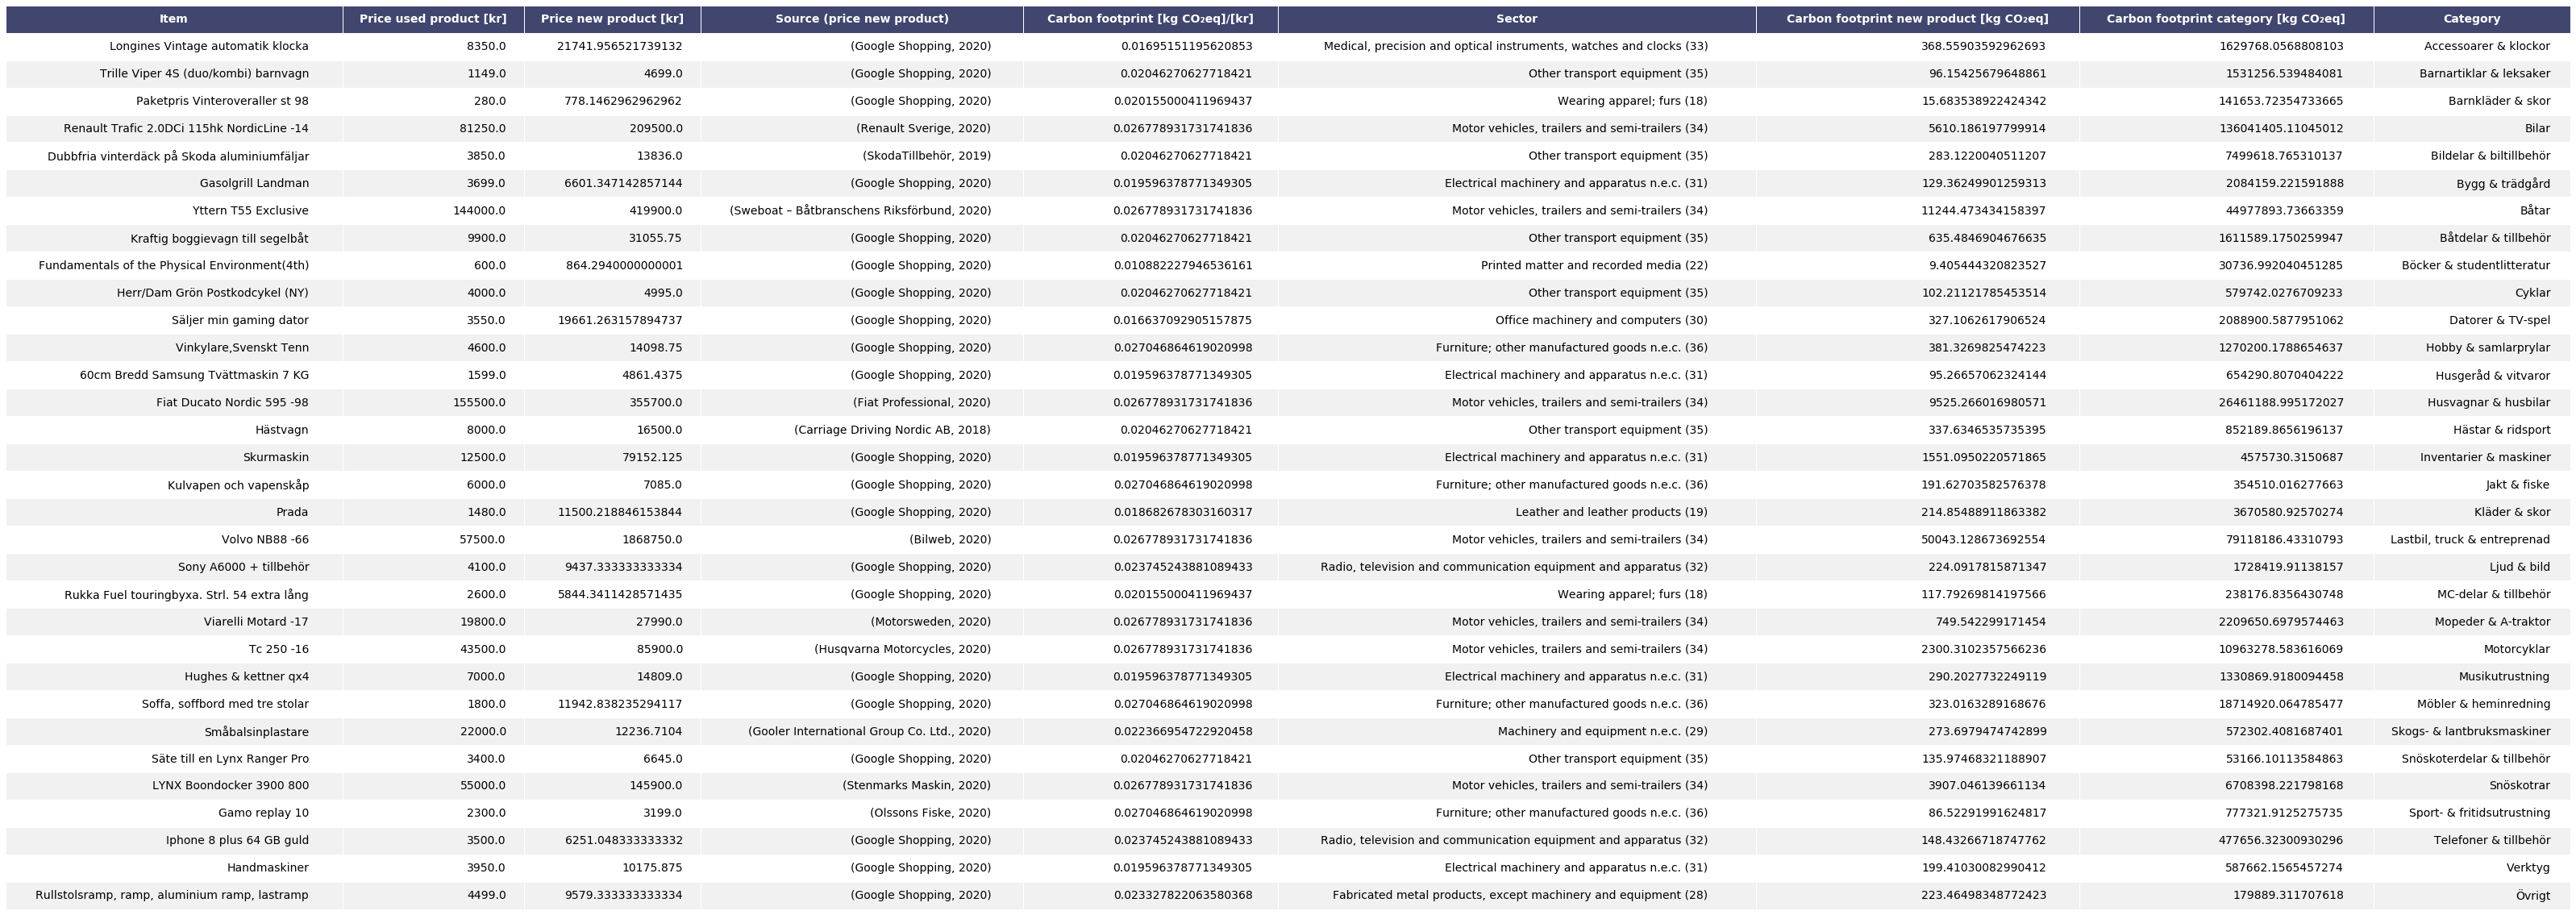

In [22]:
fig = render_mpl_table(df_category_footprint, header_columns=0, col_width=6.0, index='no').get_figure()
fig.savefig('tables/category_footprint.png')

## Calculating the potential environmental benefits in total

In [33]:
# sum of the carbon emissions of each category

In [22]:
environmental_benefit = 0

for category_footprint in df_category_footprint['Carbon footprint category [kg CO\u2082eq]'].tolist():
    environmental_benefit = environmental_benefit + category_footprint
    
print(str(environmental_benefit) + ' [Kg CO\u2082eq]') 

359715313.91957104 [Kg CO₂eq]


# Potential environmental rebound effects

## Respending and reinvestiment effects

### Calculating the carbon footprint per SEK for Swedish households

In [13]:
exio3 = pymrio.parse_exiobase3('C:\\Users\\keseljoa\\Desktop\\IOT\\IOT_2011_pxp')

In [14]:
exio3.calc_all()

In [23]:
characterization = pd.read_csv('characterization_factors\\EXIOBASE341f_CC500f.csv',',', header=[0], index_col = [0])

In [24]:
Y = exio3.Y.SE.groupby(level=1, sort=False).sum()[['Final consumption expenditure by households']]
Y

category,Final consumption expenditure by households
sector,
Paddy rice,0.123462
Wheat,246.195003
Cereal grains nec,33.096102
"Vegetables, fruit, nuts",1394.192773
Oil seeds,259.320041
...,...
Membership organisation services n.e.c. (91),1.551583
"Recreational, cultural and sporting services (92)",6476.957006
Other services (93),3076.329140


In [25]:
D_cba_SE = exio3.satellite.D_cba.SE.T

In [26]:
df1 = characterization.copy()
df2 = D_cba_SE.copy()

characterization = df1.drop([idx for idx in df1.index if idx in df1.index and idx not in df2.columns], axis=0)
D_cba_SE = df2.drop([col for col in df2.columns if col in df2.columns and col not in df1.index], axis=1)

In [27]:
# Impact of total consumption per sector
# Impact per M.EUR (total consumption)

D_cba_SE_footprints = D_cba_SE.dot(characterization)

In [28]:
 D_cba_SE_footprints[['GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']]

,"GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)"
sector,
Paddy rice,4.321874e+05
Wheat,2.763607e+08
Cereal grains nec,4.040674e+07
"Vegetables, fruit, nuts",7.271942e+08
Oil seeds,1.903610e+08
...,...
Membership organisation services n.e.c. (91),2.163705e+09
"Recreational, cultural and sporting services (92)",1.117956e+09
Other services (93),4.415778e+08


In [29]:
# Dividing the matrix impact of total consumption (D_cba_SE) by the matrix total consumption (Y) to find the consumption intensity factors
# CO2 per M.EUR
co2_per_MEUR = D_cba_SE_footprints[['GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']].div(Y['Final consumption expenditure by households'], axis=0)
co2_per_MEUR

,"GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)"
sector,
Paddy rice,3.500561e+06
Wheat,1.122528e+06
Cereal grains nec,1.220891e+06
"Vegetables, fruit, nuts",5.215880e+05
Oil seeds,7.340776e+05
...,...
Membership organisation services n.e.c. (91),1.394515e+09
"Recreational, cultural and sporting services (92)",1.726051e+05
Other services (93),1.435405e+05


In [30]:
# Merging the two matrices
multi = Y.merge(co2_per_MEUR, on='sector')
multi

,Final consumption expenditure by households,"GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)"
sector,,
Paddy rice,0.123462,3.500561e+06
Wheat,246.195003,1.122528e+06
Cereal grains nec,33.096102,1.220891e+06
"Vegetables, fruit, nuts",1394.192773,5.215880e+05
Oil seeds,259.320041,7.340776e+05
...,...,...
Membership organisation services n.e.c. (91),1.551583,1.394515e+09
"Recreational, cultural and sporting services (92)",6476.957006,1.726051e+05
Other services (93),3076.329140,1.435405e+05


In [31]:
# calculating the weighted average
#(df["quantity"] * df["weight"]).sum() / df["weight"].sum()
# kg per euros
household_emissions_per_EUR = (multi['GHG emissions (GWP100)|kg CO2 eq.|Problem oriented approach: baseline (CML, 2001)|GWP100 (IPCC, 2007)']*multi['Final consumption expenditure by households']).sum()/multi['Final consumption expenditure by households'].sum()/M_EUR
household_emissions_per_EUR

0.5669875212908857

In [32]:
household_emissions_per_SEK = household_emissions_per_EUR/EUR_TO_SEK*INFLATION_EUR_2011_2020

In [33]:
print(str(household_emissions_per_SEK) + ' [Kg CO\u2082eq]/[SEK]') 

0.05909003334006144 [Kg CO₂eq]/[SEK]


### Calculating the respending effect

Considering all the savings are respent:

In [34]:
respending_total = 0

for category, category_footprint, price_new_product, price_used_product in zip(df_category_footprint['Category'].tolist(), df_category_footprint['Carbon footprint category [kg CO\u2082eq]'].tolist(), df_category_footprint['Price new product [kr]'], df_category_footprint['Price used product [kr]']):
    respending_per_product = price_new_product - price_used_product
    number_of_products = len(df.loc[df['Category'] == category].index)
    respending_total = respending_total + respending_per_product*number_of_products
    
print(str(respending_total) + ' SEK') 

9746882397.150585 SEK


In [35]:
respending_effect = respending_total*household_emissions_per_SEK
print(str(respending_effect) + ' [Kg CO\u2082eq]') 

575943605.809286 [Kg CO₂eq]


### Calculating the reinvestment effect

Considering all the profits are reinvested:

In [36]:
reinvestment_total = 0

for category, category_footprint, price_new_product, price_used_product in zip(df_category_footprint['Category'].tolist(), df_category_footprint['Carbon footprint category [kg CO\u2082eq]'].tolist(), df_category_footprint['Price new product [kr]'], df_category_footprint['Price used product [kr]']):
    reinvestment_per_product = price_used_product
    number_of_products = len(df.loc[df['Category'] == category].index)
    reinvestment_total = reinvestment_total + reinvestment_per_product*number_of_products
    
print(str(reinvestment_total) + ' SEK') 

4108544071.0 SEK


In [37]:
reinvestment_effect = reinvestment_total*household_emissions_per_SEK
print(str(reinvestment_effect) + ' [Kg CO\u2082eq]') 

242774006.13450176 [Kg CO₂eq]


## Imperfect Substitution effect

### Calculating the imperfect substitution effect

Considering the imperfect substitution happens equally for all the product categories and none of the new products are substituted:

In [38]:
imperfect_substitution_rate = 1
imperfect_substitution_effect = imperfect_substitution_rate*environmental_benefit
print(str(imperfect_substitution_effect) + ' [Kg CO\u2082eq]') 

359715313.91957104 [Kg CO₂eq]


## Potential environmental benefit after rebound

In [45]:
#rebound_effect = reinvestment_effect + respending_effect + imperfect_substitution_effect
#potential_benefit = environmental_benefit - rebound_effect
#potential_benefit = environmental_benefit - reinvestment_rate*(reinvestment_effect + respending_effect) - imperfect_substitution_rate*environmental_benefit

#Z: potential_benefit
#Y: respending/reinvestment_rate
#X: imperfect_substitution_rate

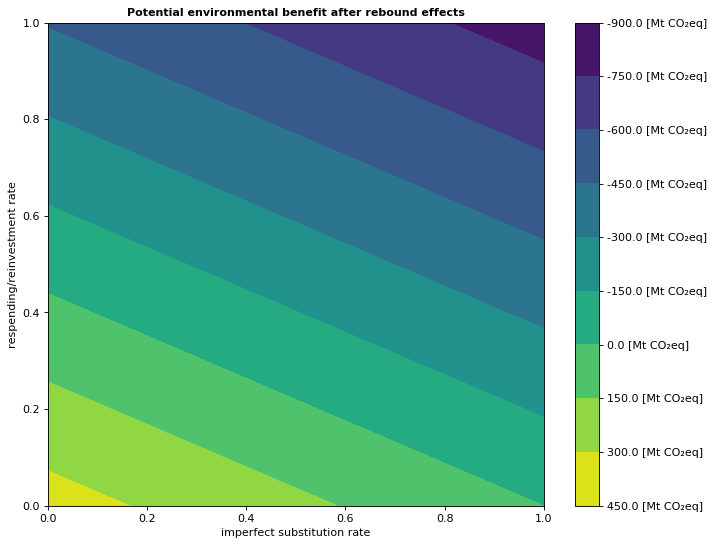

In [42]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.pyplot import figure

figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

kg_to_Mt = 1/10**6

a = environmental_benefit*kg_to_Mt
b = (reinvestment_effect + respending_effect)*kg_to_Mt
c = (imperfect_substitution_effect)*kg_to_Mt
def z_func(x,y):
 return a-y*b-x*c

x = np.arange(0.0, 1.2, 0.2)
y = np.arange(0.0, 1.2, 0.2)

X, Y = np.meshgrid(x, y)
Z = z_func(X, Y)

plt.contourf(X, Y, Z)
cbar = plt.colorbar(format='%.01f [Mt CO\u2082eq]')
cbar.ax.invert_yaxis()

plt.xlabel('imperfect substitution rate')
plt.ylabel('respending/reinvestment rate')
plt.title("Potential environmental benefit after rebound effects", fontweight="bold", fontsize="10")
plt.savefig('charts/color map_environmental benefit after rebound.jpg', bbox_inches = "tight") 
plt.show()

# Appendix A: Code in Python

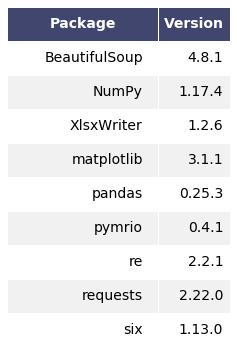

In [23]:
data_packages = [['requests', requests.__version__],
['BeautifulSoup', bs4.__version__],
['XlsxWriter', xlsxwriter.__version__],
['re', re.__version__],
['pandas', pd.__version__],
['matplotlib', matplotlib.__version__],
['NumPy', np.__version__],
['six', six.__version__],
['pymrio', pymrio.__version__]]

df_packages = pd.DataFrame(data_packages, columns = ['Package', 'Version']).sort_values(by ='Package')

fig = render_mpl_table(df_packages, header_columns=0, col_width=2.0, index_col_width=0, index='no').get_figure()
fig.savefig('tables/packages.png')

# Appendix B: Categories in English

Categories translated from Swedish to English:

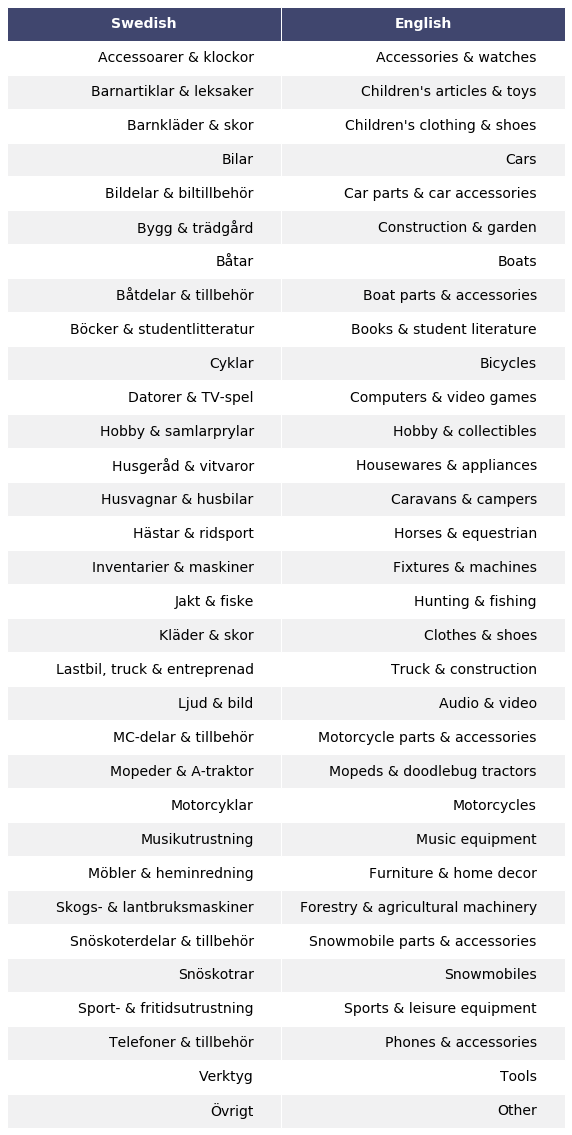

In [33]:
data_translations = [['Motorcyklar', 'Motorcycles'],
['Bildelar & biltillbehör', 'Car parts & car accessories'],
['Möbler & heminredning', 'Furniture & home decor'],
['Sport- & fritidsutrustning', 'Sports & leisure equipment'],
['Barnkläder & skor', 'Children\'s clothing & shoes'],
['MC-delar & tillbehör', 'Motorcycle parts & accessories'],
['Ljud & bild', 'Audio & video'],
['Bilar', 'Cars'],
['Datorer & TV-spel', 'Computers & video games'],
['Bygg & trädgård', 'Construction & garden'],
['Övrigt', 'Other'],
['Husgeråd & vitvaror', 'Housewares & appliances'],
['Kläder & skor', 'Clothes & shoes'],
['Barnartiklar & leksaker', 'Children\'s articles & toys'],
['Husvagnar & husbilar', 'Caravans & campers'],
['Skogs- & lantbruksmaskiner', 'Forestry & agricultural machinery'],
['Musikutrustning', 'Music equipment'],
['Inventarier & maskiner', 'Fixtures & machines'],
['Telefoner & tillbehör', 'Phones & accessories'],
['Böcker & studentlitteratur', 'Books & student literature'],
['Verktyg', 'Tools'],
['Hästar & ridsport', 'Horses & equestrian'],
['Båtdelar & tillbehör', 'Boat parts & accessories'],
['Mopeder & A-traktor', 'Mopeds & doodlebug tractors'],
['Cyklar', 'Bicycles'],
['Lastbil, truck & entreprenad', 'Truck & construction'],
['Båtar', 'Boats'],
['Snöskotrar', 'Snowmobiles'],
['Accessoarer & klockor', 'Accessories & watches'],
['Hobby & samlarprylar', 'Hobby & collectibles'],
['Jakt & fiske', 'Hunting & fishing'],
['Snöskoterdelar & tillbehör', 'Snowmobile parts & accessories']]

df_translations = pd.DataFrame(data_translations, columns = ['Swedish', 'English']).sort_values(by ='Swedish')

fig = render_mpl_table(df_translations, header_columns=0, col_width=5.0, index_col_width=0, index='no').get_figure()
fig.savefig('tables/translations.png')